In [2]:
import pandas as pd

df_comments = pd.read_csv('youtube_comments_dataset.csv')
print(df_comments['text'].head(20))

0     Bismilahrahmanrahim İslam'ın en azından çocukl...
1                        STUPID LOOP that shows NOTHING
2           Where there is Islam, there is destruction.
3     Europe Union, Europe kommision and OSN is the ...
4                                        Free Palestine
5                                               YouTube
6     Israel bilkul sahi hai war jinhone start Kiya ...
7                                               YouTube
8     Name me 1 thing Islam has brought to the world...
9                          The maths you use every day.
10    ​ @Titus9508 the maths we use today  is from t...
11               ​@Titus9508  Came from the Greeks mate
12     @Titus9508 😂😂 lol Muhammad was illiterate😂 he...
13          @TomGodson95 it didn’t come from the greeks
14    ​ @Titus9508 maths is older than islam over 88...
15    Islam\nHas brought only death, destruction and...
16    ITS SELF ISLAM WHICH THOUGHT U NOT TO KILL WOM...
17    ​ @cuttingman007 BT PROPHET MUHAMMAD SALLA

**Comment Cleaning and Preprocessing**


Remove URLs, Remove Usernames/Handles, keep emojis and emoticons, remove excess whitespace, remove non-UTF characters


In [3]:
import re

def preprocess_comments_VADER(text):
    """
    Preprocess a YouTube comment for VADER sentiment analysis.
    Keeps minimal cleaning to retain social media-specific context.
    """
    if not isinstance(text, str):
        return ""  # Return empty string if it's not a string (e.g., NaN or float)
    
    # Remove URLs
    text = re.sub(r"http\S+|www\S+", "", text)
    
    # Remove mentions (@username)
    text = re.sub(r"@\w+", "", text)
    
    # Remove excessive spaces (replace multiple spaces or tabs with a single space)
    text = re.sub(r"\s+", " ", text).strip()
    
    # Remove newlines and carriage returns
    text = text.replace("\n", " ").replace("\r", " ")

    # Ensure text is valid UTF-8 (ignore non-ASCII characters that are not emojis)
    # Emojis are encoded in UTF-8, so we want to keep those
    text = text.encode("utf-8", "ignore").decode("utf-8", "ignore")
    
    return text


**VADER Sentiment Score**

https://github.com/cjhutto/vaderSentiment


In [4]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd

length = len(df_comments)

# Initialize the VADER SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Iterate through all comments in the DataFrame and analyze sentiment
for index, row in df_comments.iterrows():
    # Preprocess the comment
    comment_text = row["text"]
    preprocessed_text = preprocess_comments_VADER(comment_text)
    
    # Get VADER sentiment for the preprocessed comment
    sentiment = analyzer.polarity_scores(preprocessed_text)
    
    # Add sentiment scores to the DataFrame directly
    df_comments.loc[index, 'negative'] = sentiment['neg']
    df_comments.loc[index, 'neutral'] = sentiment['neu']
    df_comments.loc[index, 'positive'] = sentiment['pos']
    df_comments.loc[index, 'compound'] = sentiment['compound']
    
    # Every 1000 comments, print the current progress on the same line
    if (index + 1) % 1000 == 0:
        print(f"\rProcessed {index + 1} out of {length} comments", end="")

# Save the resulting DataFrame to a new CSV
df_comments.to_csv("youtube_comments_VADER.csv", index=False)

print(f"\nSaved comments with sentiment scores")


Processed 73000 out of 73479 comments
Saved comments with sentiment scores


There are a lot of neutral, but I think that's actually pretty normal.


**Emotion English DistilRoBERTa-base**

https://huggingface.co/j-hartmann/emotion-english-distilroberta-base


In [5]:
df_comments = pd.read_csv("youtube_comments_VADER.csv")

In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load the tokenizer and model
model_name = "cardiffnlp/twitter-roberta-base-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)


c:\Users\abeba\OneDrive\Desktop\Summer Research - Extremism\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\abeba\OneDrive\Desktop\Summer Research - Extremism\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\abeba\.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-emotion. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate 

remove emojis, URLs, special characters, user mentions, punctuation, stop words, whitespace, non-utf


In [7]:
import re

def preprocess_for_emotion_analysis(text):
    if not isinstance(text, str):
        return ""  # Return empty string if it's not a string (e.g., NaN or float)
    
    # Remove URLs
    text = re.sub(r"http\S+|www\S+", "", text)
    
    # Remove mentions (@username)
    text = re.sub(r"@\w+", "", text)
    
    # Remove excessive spaces (replace multiple spaces or tabs with a single space)
    text = re.sub(r"\s+", " ", text).strip()
    
    # Remove newlines and carriage returns
    text = text.replace("\n", " ").replace("\r", " ")

    # Remove emojis using regex
    emoji_pattern = re.compile("[\U00010000-\U0010ffff]", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Ensure text is valid UTF-8 (ignore non-ASCII characters that are not emojis)
    text = text.encode("utf-8", "ignore").decode("utf-8", "ignore")

    return text


In [8]:
def preprocess_for_roberta(text):
    """
    Preprocess the comment text for the Emotion DistilRoBERTa model.
    Tokenizes the text and prepares it for input into the model.
    """
    # Tokenize the text using the DistilRoBERTa tokenizer
    encoding = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt")
    
    return encoding


In [9]:
import torch

def get_emotions_with_scores(text):
    # Preprocess the text
    inputs = preprocess_for_roberta(text)

    # Run the model
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the probabilities (softmax applied)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    
    # Get all emotion labels from the model config (mapping of ids to labels)
    emotion_labels = model.config.id2label  # This gives the mapping of token IDs to emotion labels
    emotion_scores = probs[0].cpu().numpy()  # Get all scores for the first sample in the batch (as we're processing a single comment)

    # Create a list of emotion-label and score pairs
    emotions_with_scores = [(emotion_labels[i], emotion_scores[i]) for i in range(len(emotion_labels))]
    
    return emotions_with_scores



In [10]:
import pandas as pd

def apply_emotion_model(df_comments):
    # Length of DataFrame for progress tracking
    length = len(df_comments)

    # Iterate through all comments in the DataFrame and analyze emotion
    for index, row in df_comments.iterrows():
        comment_text = row['text']
        
        # Preprocess the comment (remove unwanted parts like emojis, URLs, mentions)
        preprocessed_text = preprocess_for_emotion_analysis(comment_text)
        
        # Get emotion predictions and their scores after preprocessing
        emotions = get_emotions_with_scores(preprocessed_text)  # Assume this returns a list of (emotion, score) tuples
        
        # Add the emotion scores to the DataFrame directly
        for emotion, score in emotions:
            df_comments.loc[index, f'{emotion}_score'] = score  # Add emotion score as a new column

        # Print progress every 1000 comments (updating the same line)
        if (index + 1) % 1000 == 0:
            print(f"\rProcessed {index + 1} out of {length} comments", end="")

    # Save the resulting DataFrame to a new CSV
    df_comments.to_csv('youtube_comments_with_emotions.csv', index=False)

    print(f"\nSaved comments with emotion predictions to 'youtube_comments_with_emotions.csv'")


In [11]:
# Run the emotion model on the dataframe
apply_emotion_model(df_comments)

Processed 73000 out of 73479 comments
Saved comments with emotion predictions to 'youtube_comments_with_emotions.csv'


In [12]:
# Iterate through each row and find the emotion with the highest score
for index, row in df_comments.iterrows():
    # Find the emotion column names that have the score values
    emotion_scores = {col: row[col] for col in df_comments.columns if '_score' in col}
    
    # Find the emotion with the highest score
    highest_emotion = max(emotion_scores, key=emotion_scores.get)
    
    # Extract the emotion label (from the column name)
    emotion_label = highest_emotion.replace('_score', '')
    
    # Add only the emotion to the dataframe
    df_comments.loc[index, 'emotion'] = emotion_label

# Save the updated dataframe
df_comments.to_csv("youtube_comments_with_emotion_column.csv", index=False)

print("Added 'emotion' column and saved to 'youtube_comments_with_emotion_column.csv'")


Added 'emotion' column and saved to 'youtube_comments_with_emotion_column.csv'


testing CARDIFF


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import pandas as pd
from tqdm import tqdm
import re

# Load data
df = pd.read_csv('youtube_comments_dataset.csv')

# Define the preprocessing function
def preprocess_comments_transformer(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    text = text.replace("\n", " ").replace("\r", " ")
    emoji_pattern = re.compile("[\U00010000-\U0010ffff]", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    text = text.encode("utf-8", "ignore").decode("utf-8", "ignore")
    return text

# Preprocess text
df['preprocessed_text'] = df['text'].fillna('').apply(preprocess_comments_transformer)

# Load model & tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Function to get sentiment scores
def get_transformer_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    return {
        'negative': probs[0][0].item(),
        'neutral': probs[0][1].item(),
        'positive': probs[0][2].item()
    }

# Apply with tqdm
tqdm.pandas()
sentiment_scores = df['preprocessed_text'].progress_apply(get_transformer_sentiment)
df = pd.concat([df, sentiment_scores.apply(pd.Series)], axis=1)

# Save
df.to_csv('youtube_comments_transformer_sentiment.csv', index=False)
print("✅ Saved comments with transformer sentiment scores")


  4%|▍         | 3267/73479 [09:44<3:31:03,  5.54it/s] 

Note, should probably drop comments that are not in english...


**Filtering things that aren't english**


In [13]:
import pandas as pd

df_comments = pd.read_csv("youtube_comments_with_emotion_column.csv")

In [14]:
from langdetect import detect, DetectorFactory

# Fix randomness issue in langdetect
DetectorFactory.seed = 0

def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False  # If detection fails, assume it's not English

# Create a DataFrame for non-English comments
df_non_english = df_comments[~df_comments['text'].apply(is_english)]

# Print the count
print(f"Number of non-English comments: {len(df_non_english)}")


ModuleNotFoundError: No module named 'langdetect'

In [ ]:
df_non_english.to_csv('non_english_comments.csv', index=False)

**Most of this is pretty much still english. (so I wont drop)** Did not filter emojis or what not... Also people have bad spelling. Maybe I'll just leave it for now? We can always take it out and run the "analysis/visualizations" again easily.


VADER sentiment thresholds


In [ ]:
 # Classify sentiment based on thresholds
def classify_sentiment(compound_score, pos, neg):
    if compound_score >= pos:
        return "positive"
    elif compound_score <= neg:
        return "negative"
    else:
        return "neutral"

In [ ]:


def count_sentiment_classes(df, threshold_positive=0.05, threshold_negative=-0.05):
    """
    Count the number of comments in each sentiment class (positive, neutral, negative)
    based on the given thresholds for compound sentiment score.
    
    Args:
    - df (pd.DataFrame): The DataFrame with the sentiment scores.
    - threshold_positive (float): The threshold for positive sentiment.
    - threshold_negative (float): The threshold for negative sentiment.
    
    Returns:
    - dict: A dictionary with counts of 'positive', 'neutral', and 'negative' classes.
    """
    
    # Apply the classification to each row based on the 'compound' score
    df['sentiment_class'] = df['compound'].apply(lambda x: classify_sentiment(x, threshold_positive, threshold_negative))
    
    # Count the occurrences of each sentiment class
    sentiment_counts = df['sentiment_class'].value_counts()
    
    return sentiment_counts

# Example usage:

new_sentiment_counts = count_sentiment_classes(df_comments, threshold_positive=0.05, threshold_negative=-0.05)
print("Sentiment class counts with +-0.05:", new_sentiment_counts)
print()

new_sentiment_counts = count_sentiment_classes(df_comments, threshold_positive=0.1, threshold_negative=-0.1)
print("Sentiment class counts with +-0.1:", new_sentiment_counts)
print()

new_sentiment_counts = count_sentiment_classes(df_comments, threshold_positive=0.2, threshold_negative=-0.2)
print("Sentiment class counts with +-0.2:", new_sentiment_counts)
print()

new_sentiment_counts = count_sentiment_classes(df_comments, threshold_positive=0.4, threshold_negative=-0.4)
print("Sentiment class counts with +-0.4:", new_sentiment_counts)
print()

new_sentiment_counts = count_sentiment_classes(df_comments, threshold_positive=0.5, threshold_negative=-0.5)
print("Sentiment class counts with +-0.5:", new_sentiment_counts)
print()

Sentiment class counts with +-0.05: sentiment_class
negative    29012
positive    23664
neutral     20842
Name: count, dtype: int64

Sentiment class counts with +-0.1: sentiment_class
negative    28345
positive    22924
neutral     22249
Name: count, dtype: int64

Sentiment class counts with +-0.2: sentiment_class
negative    26915
neutral     24964
positive    21639
Name: count, dtype: int64

Sentiment class counts with +-0.4: sentiment_class
neutral     34747
negative    21863
positive    16908
Name: count, dtype: int64

Sentiment class counts with +-0.5: sentiment_class
neutral     42462
negative    18097
positive    12959
Name: count, dtype: int64



_let's go with 0.1 for the time being_


In [ ]:
# Apply the sentiment classification to the DataFrame based on the chosen thresholds
df_comments['sentiment_class'] = df_comments['compound'].apply(lambda x: classify_sentiment(x, pos=0.1, neg=-0.1))

# Save the updated DataFrame with the 'sentiment_class' column
df_comments.to_csv("youtube_comments_with_sentiment_class.csv", index=False)

print("Sentiment classes applied and saved to 'youtube_comments_with_sentiment_class.csv'")

Sentiment classes applied and saved to 'youtube_comments_with_sentiment_class.csv'


_bit of cleaning_


In [ ]:
# Check for missing values
df = pd.read_csv("youtube_comments_with_sentiment_class.csv")

missing_data = df.isnull().sum()
print(missing_data)

df = df.dropna()

rank                  0
video_id              0
title                 0
channel_name          0
comment_id            0
text                  3
parent_id             0
author               36
author_channel_id     0
likes                 0
timestamp             0
negative              0
neutral               0
positive              0
compound              0
anger_score           0
disgust_score         0
fear_score            0
joy_score             0
neutral_score         0
sadness_score         0
surprise_score        0
emotion               0
sentiment_class       0
dtype: int64


In [ ]:
# Convert Unix timestamps to pandas datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

# Convert to just the date part, discarding time (00:00:00)
df['timestamp'] = df['timestamp'].dt.date

# Verify the conversion
print(df['timestamp'].head())


0    2024-11-20
1    2024-10-20
2    2024-10-20
3    2024-10-20
4    2024-10-20
Name: timestamp, dtype: object


In [ ]:
df.to_csv('youtube_comments_final.csv', index=False)

**VISUALIZATIONS**


In [ ]:
import pandas as pd

df_comments = pd.read_csv('youtube_comments_final.csv')

**--- Comment Dataset ---**

_-- General --_

Comment frequency over time?
Any Top Commentors?
Highly liked comments?
Comments with most replies?
comment length distribution?


top commentors?


In [ ]:
# Group by author_channel_id and video_id and count the number of unique videos per author_channel_id
author_video_count = df_comments.groupby('author_channel_id')['video_id'].nunique()

# Filter out the authors who are associated with more than one video
multiple_videos_authors = author_video_count[author_video_count > 2]

# Display the authors who are in more than one video
print("Authors in more than one video:")
print(multiple_videos_authors)

# If you want to also see the video_ids associated with each author:
authors_multiple_videos = df[df['author_channel_id'].isin(multiple_videos_authors.index)]
print("\nAuthors and the corresponding videos they commented on:")
print(authors_multiple_videos[['author_channel_id', 'video_id']].drop_duplicates())


Authors in more than one video:
author_channel_id
UC-SAVtfnz3NUe9XA83nvCnA    3
UC0tSYOKGAUWH91FW25udN3A    3
UC1aYNm9EUC7yehYu2o907yQ    3
UC2kWl1ASswv3kb8FSD0LRZA    4
UC2lhwPBh2i-1mqMqo3q09iQ    4
                           ..
UCxHv5RBAYyffPeexDEpb6aA    3
UCy1hSgQnZil0uKrJpO-tQ4A    3
UCyiS7We3kOM8QBtWPpF6vBw    3
UCzUN_DpBpm2yGMmrvDttSSg    3
UCzyrtnpt-l7bg3qKrm7W3iQ    3
Name: video_id, Length: 131, dtype: int64

Authors and the corresponding videos they commented on:
              author_channel_id     video_id
1      UCCyq9ZDntJqdbrLaVepVaMg  rzIVd35dGZ4
11     UC2lhwPBh2i-1mqMqo3q09iQ  rzIVd35dGZ4
25     UCh6MvPGKUD2eDw7jesD93ZA  rzIVd35dGZ4
37     UC_O29X0xE2LR2O9OPvqwOow  rzIVd35dGZ4
68     UC8PhXy1UKJ1LNg4nUH7HLRg  Ulg-96K3qMc
...                         ...          ...
73301  UCcvMAk_fy2Sx8k5G3SiiBzg  JLMaygSKxe8
73307  UCGoOlveyiwPavt3yUevfH4Q  JLMaygSKxe8
73421  UCQtHK7dQjBjF2bf71cbt0oQ  JLMaygSKxe8
73424  UC8qVIx5p3OoYO4r1pjKz97A  JLMaygSKxe8
73513  UCYus2v771C5KRP7x5q

In [ ]:
# Group by author_channel_id and video_id and count the number of unique videos per author_channel_id
author_video_count = df_comments.groupby('author_channel_id')['video_id'].nunique()

# Filter out the authors who are associated with more than one video
multiple_videos_authors = author_video_count[author_video_count > 2]

# If you want to also see the video_ids associated with each author:
authors_multiple_videos = df_comments[df_comments['author_channel_id'].isin(multiple_videos_authors.index)]

# Save the authors with more than one video, their corresponding video IDs, titles, comments, and timestamps to a CSV
authors_multiple_videos = authors_multiple_videos[['author_channel_id', 'video_id', 'title', 'text', 'timestamp']].drop_duplicates()
authors_multiple_videos.to_csv("authors_multiple_videos.csv", index=False)

print("Saved authors with multiple videos to 'authors_multiple_videos.csv'")


Saved authors with multiple videos to 'authors_multiple_videos_with_details_and_timestamp.csv'


In [ ]:
# Load the authors_multiple_videos CSV
authors_multiple_videos = pd.read_csv("authors_multiple_videos.csv")

# Count the number of comments per author
top_commenters = authors_multiple_videos['author_channel_id'].value_counts().head(10)

# Print the top commenters
print("Top Commenters (based on the number of comments):")
print(top_commenters)

Top Commenters (based on the number of comments):
author_channel_id
UClzT7HotGoAjgtg2FwWIjPA    49
UC6pPTonQbFeRAcL0gNQjB-w    40
UCpD-76AkVFsDxLOfZejMfnQ    39
UCkM2BDng1MCygBssIlAEPZg    31
UClBwPYpF_2rRdOibPSi87xA    25
UCpc3yat-KctxPLTM0q17loA    21
UCtrVDGWeKhQRK0rjMbF4jrQ    21
UCNNHiBZUM0vtBoA5ck48zdw    18
UCwWKd_3Ju7ItuATHDVd2rSA    17
UC8PhXy1UKJ1LNg4nUH7HLRg    16
Name: count, dtype: int64


_--- Video Dataset ---_

Likes vs Comments


_-- Sentiment --_

pie charts: emotion class, general sentiment class?
Distributions?


Sentiment Distribution


April 1: Changing the colour mapping to keep class colours consistent


In [ ]:
# Define a fixed color mapping
color_mapping = {'positive': '#2ca02c', 'neutral': '#1f77b4', 'negative': '#d62728'}  # Green, Blue, Red

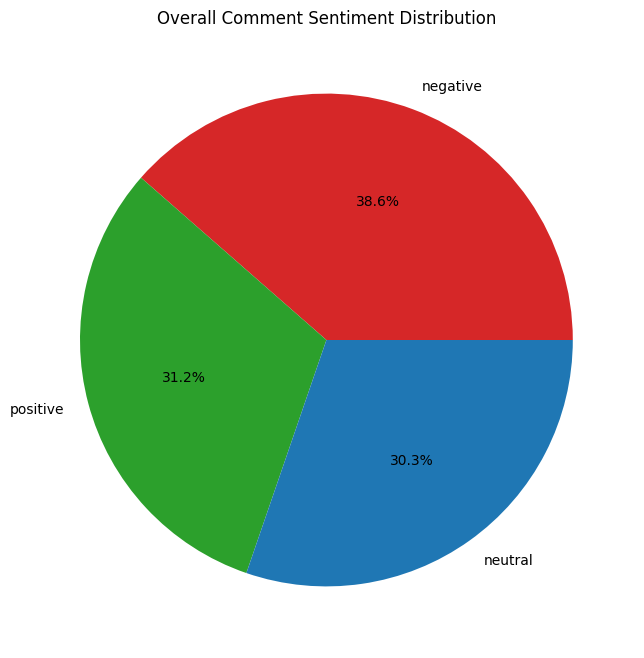

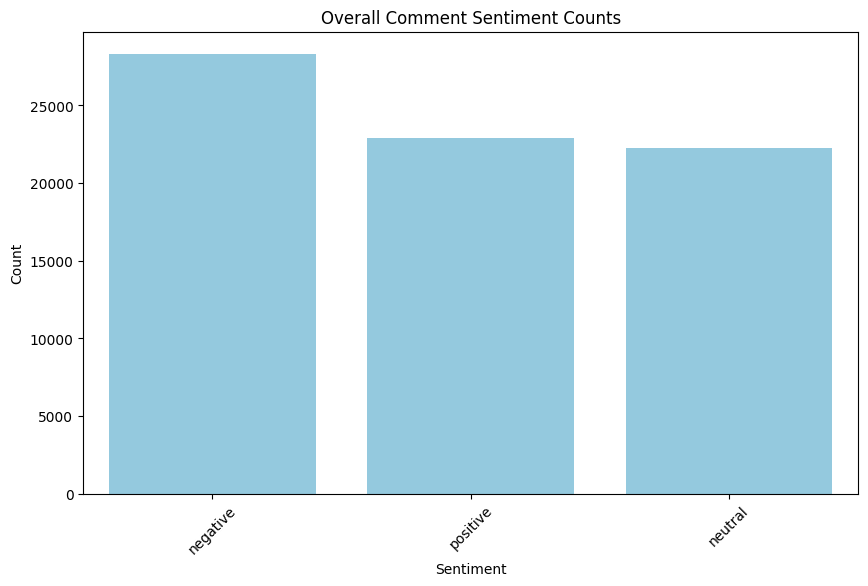

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the order is consistent
sentiment_counts = df_comments['sentiment_class'].value_counts()
colors = [color_mapping[label] for label in sentiment_counts.index]

# --- Plot the Pie Chart ---
plt.figure(figsize=(8, 8))
sentiment_counts.plot(kind='pie', autopct='%1.1f%%', colors=colors, legend=False)
plt.title('Overall Comment Sentiment Distribution')
plt.ylabel('')
plt.show()

# --- Plot the Bar Plot ---
plt.figure(figsize=(10, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, color='skyblue')
plt.title('Overall Comment Sentiment Counts')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

We can do things like this too,: Sentiment by commenter


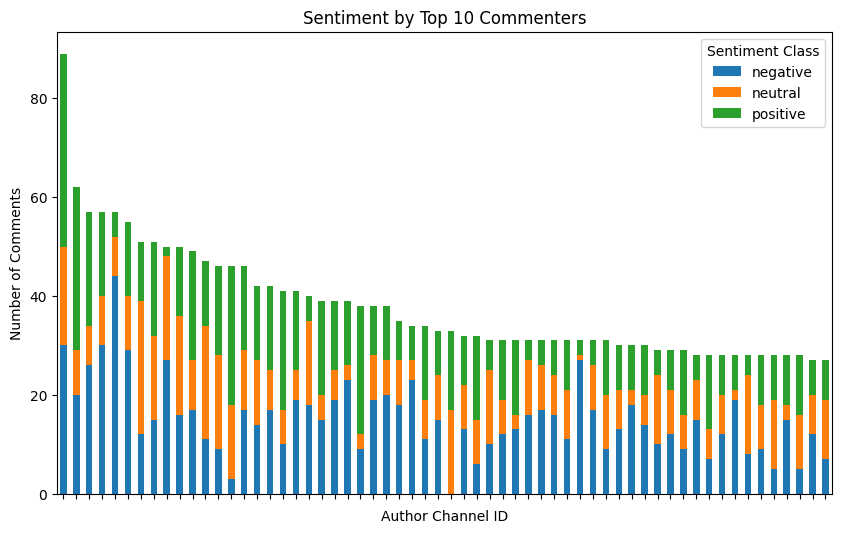

In [ ]:
# Count sentiment for each author
author_sentiment_counts = df_comments.groupby(['author_channel_id', 'sentiment_class']).size().unstack().fillna(0)

# Top 10 authors based on the total number of comments
top_10_authors = df_comments['author_channel_id'].value_counts().head(60).index

# Filter for top 10 authors and plot
top_authors_sentiment = author_sentiment_counts.loc[top_10_authors]

# Plot sentiment for top authors
ax = top_authors_sentiment.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Sentiment by Top 10 Commenters')
plt.xlabel('Author Channel ID')
plt.ylabel('Number of Comments')
plt.legend(title='Sentiment Class')

# Remove x-axis labels
plt.xticks(ticks=range(len(top_10_authors)), labels=[], rotation=0)  # Remove labels on x-axis

plt.show()


Sentiment score distribution


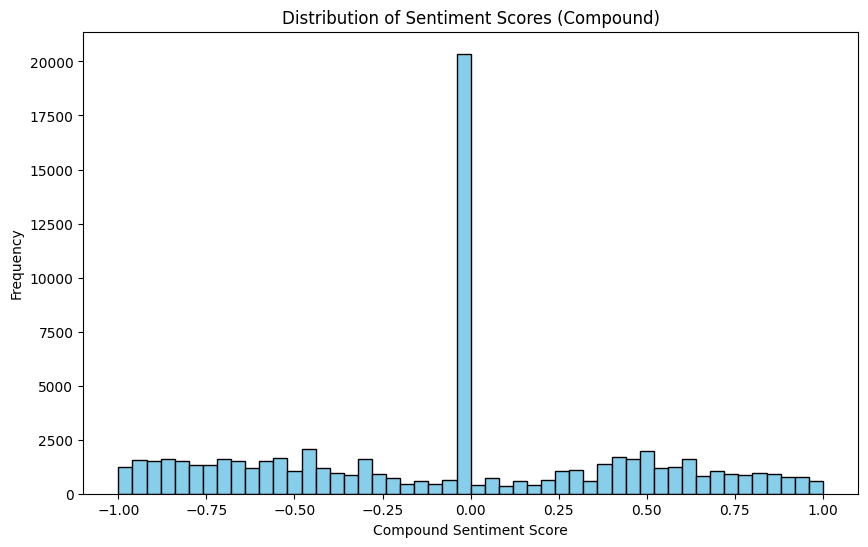

In [ ]:
# Plot the distribution of compound scores
df_comments['compound'].plot(kind='hist', bins=50, color='skyblue', edgecolor='black', figsize=(10, 6))
plt.title('Distribution of Sentiment Scores (Compound)')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Frequency')
plt.show()


Sentiment comparison with comment likes


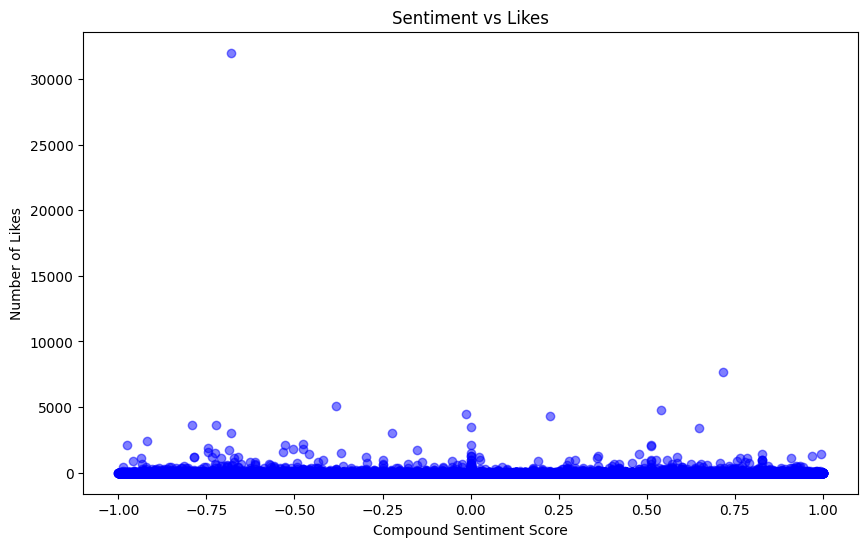

In [ ]:
# Plot sentiment vs likes
plt.figure(figsize=(10, 6))
plt.scatter(df_comments['compound'], df_comments['likes'], alpha=0.5, color='blue')
plt.title('Sentiment vs Likes')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Number of Likes')
plt.show()


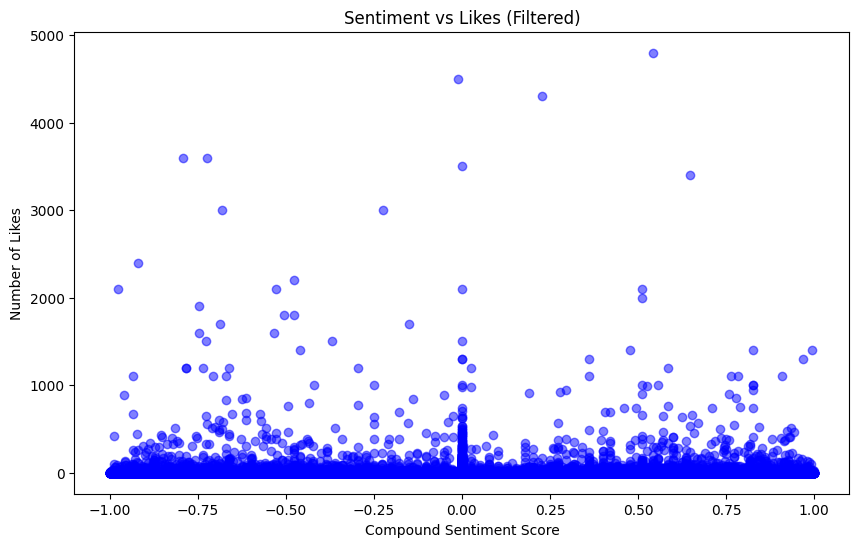

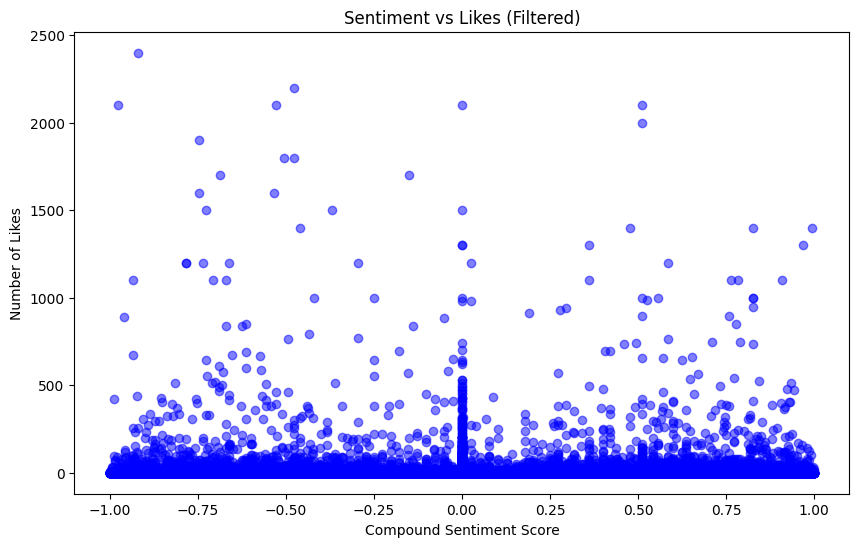

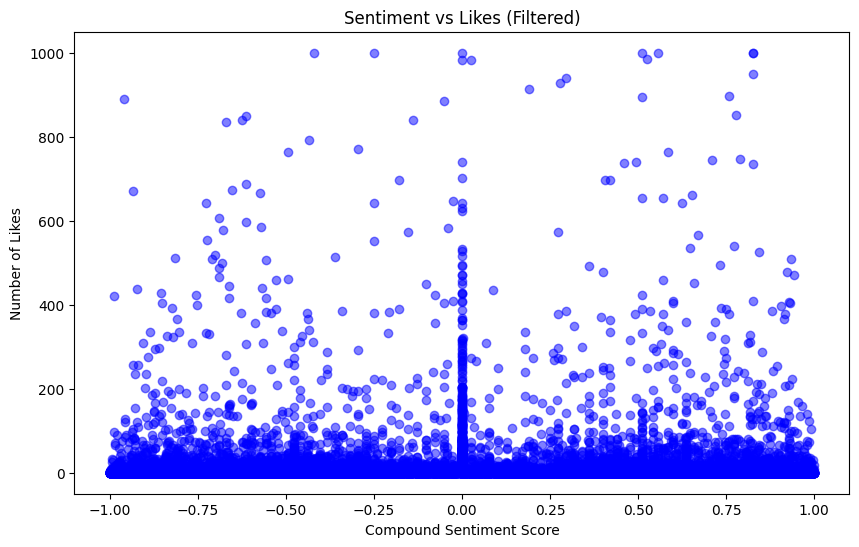

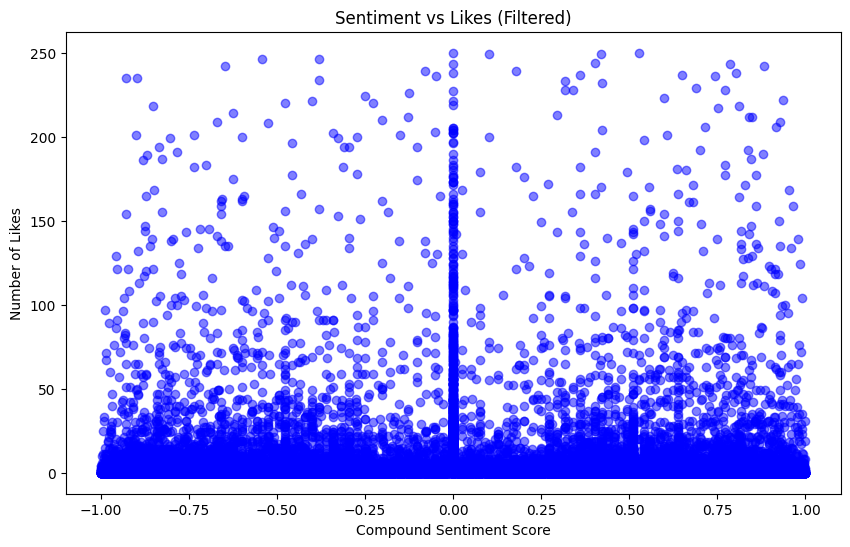

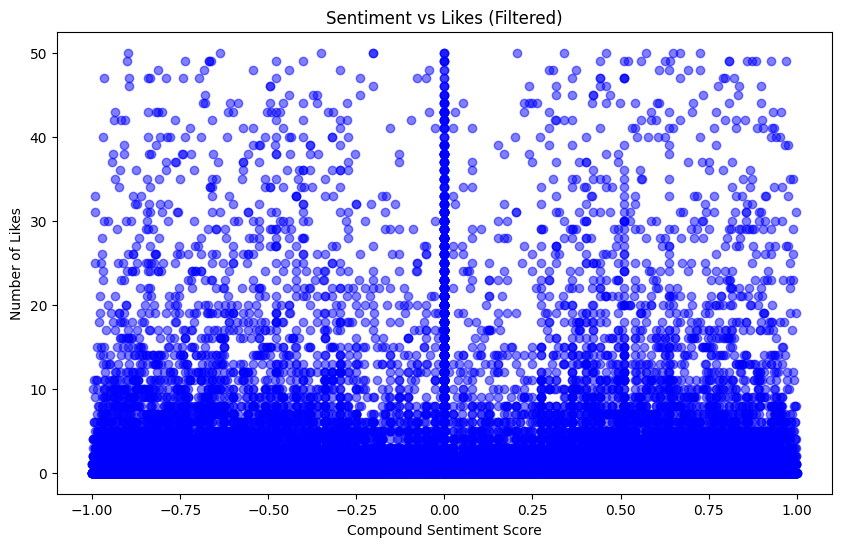

In [ ]:
thresholds = [5000, 2500, 1000, 250, 50]

for num in thresholds:
    # Filter out comments with likes greater than 5000
    df_filtered = df_comments[df_comments['likes'] <= num]

    # Plot sentiment vs likes
    plt.figure(figsize=(10, 6))
    plt.scatter(df_filtered['compound'], df_filtered['likes'], alpha=0.5, color='blue')
    plt.title('Sentiment vs Likes (Filtered: Likes <= {num})')
    plt.xlabel('Compound Sentiment Score')
    plt.ylabel('Number of Likes')
    plt.show()


In [ ]:
# Define a fixed color mapping for emotions
emotion_color_mapping = {
    'joy': 'pink',       # Pink
    'sadness': '#2ca02c',   # Green
    'anger': '#d62728',     # Red
    'surprise': '#ff7f0e',  # Orange
    'fear': '#9467bd',      # Purple
    'disgust': '#8c564b',   # Brown
    'neutral': '#1f77b4'    # Blue
}

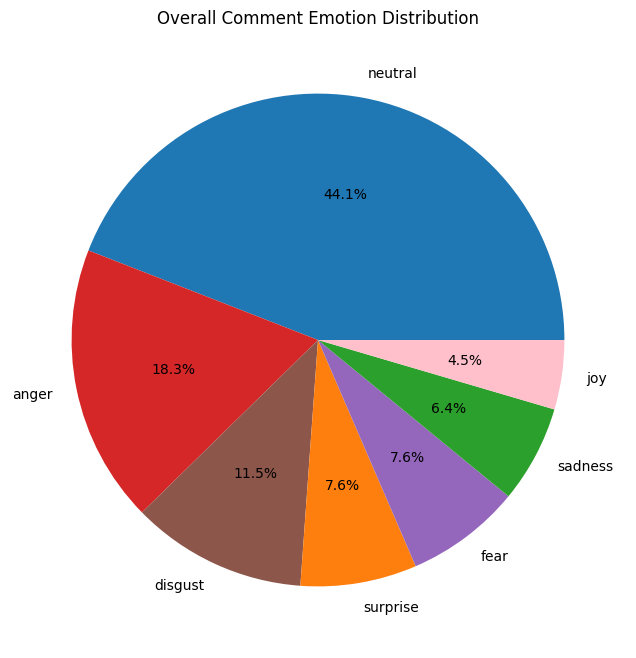

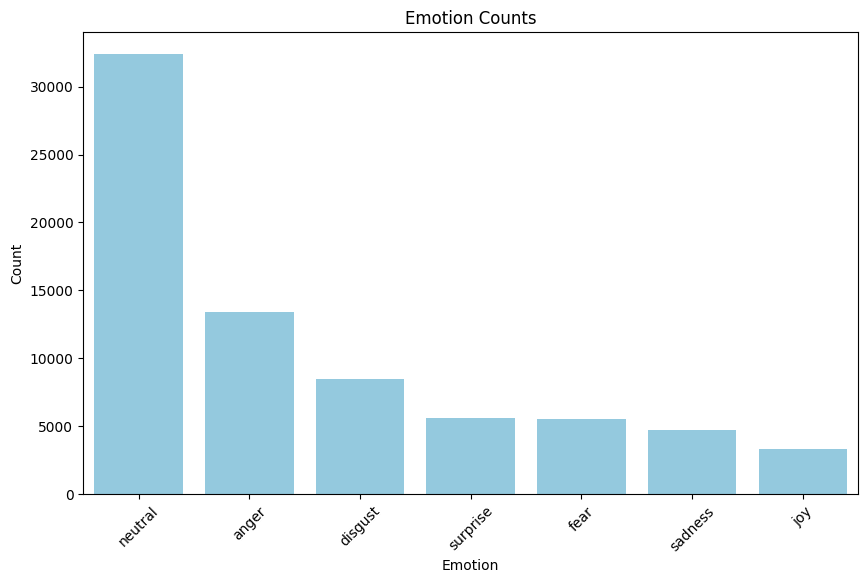

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the order is consistent
emotion_counts = df_comments['emotion'].value_counts()
colors = [emotion_color_mapping[label] for label in emotion_counts.index]

# --- Plot the Pie Chart ---
plt.figure(figsize=(8, 8))
emotion_counts.plot(kind='pie', autopct='%1.1f%%', colors=colors, legend=False)
plt.title('Overall Comment Emotion Distribution')
plt.ylabel('')  
plt.show()

# --- Plot the Bar Plot ---
plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, color='skyblue')  
plt.title('Overall Comment Emotion Counts')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


What we just visualized for sentiments but for emotions now


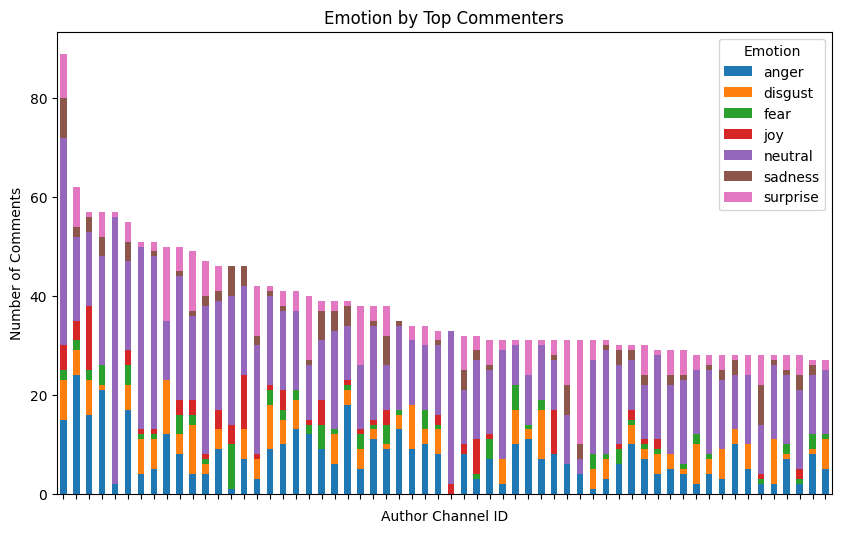

In [ ]:
# Count emotion for each author
author_emotion_counts = df_comments.groupby(['author_channel_id', 'emotion']).size().unstack().fillna(0)

# Top 10 authors based on the total number of comments
top_10_authors = df_comments['author_channel_id'].value_counts().head(60).index

# Filter for top 10 authors and plot
top_authors_emotion = author_emotion_counts.loc[top_10_authors]

# Plot emotion distribution for top authors
ax = top_authors_emotion.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Emotion by Top Commenters')
plt.xlabel('Author Channel ID')
plt.ylabel('Number of Comments')
plt.legend(title='Emotion')

# Remove x-axis labels
plt.xticks(ticks=range(len(top_10_authors)), labels=[], rotation=0)  # Remove labels on x-axis

plt.show()

C:\Users\domin\AppData\Local\Temp\ipykernel_28060\1063051609.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered2 = df_filtered[df_comments['emotion'] == emotion]


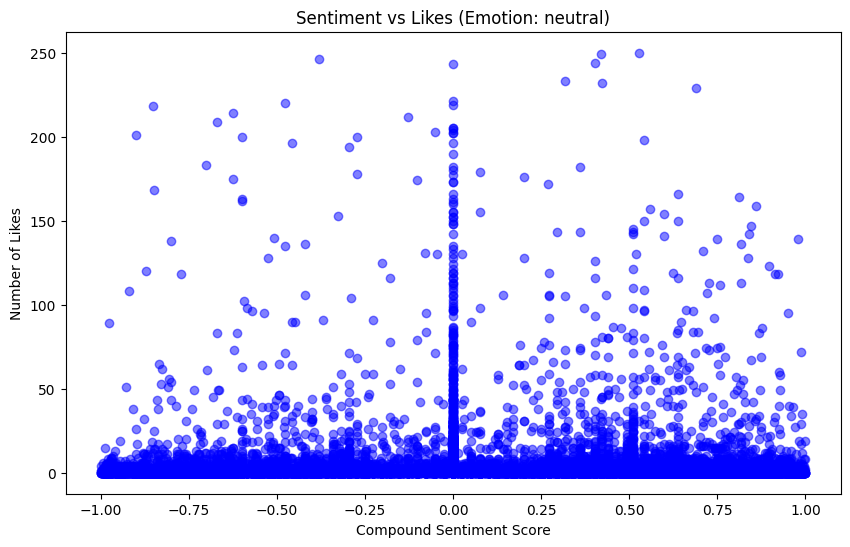

C:\Users\domin\AppData\Local\Temp\ipykernel_28060\1063051609.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered2 = df_filtered[df_comments['emotion'] == emotion]


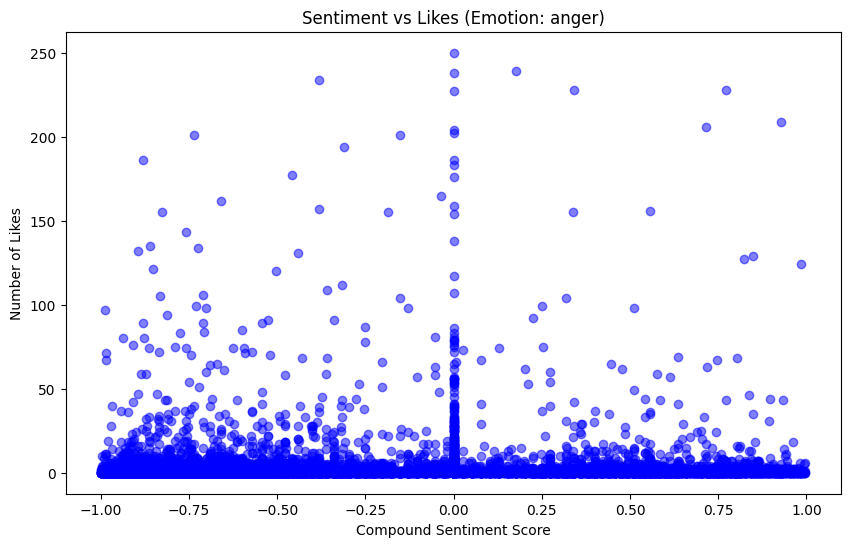

C:\Users\domin\AppData\Local\Temp\ipykernel_28060\1063051609.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered2 = df_filtered[df_comments['emotion'] == emotion]


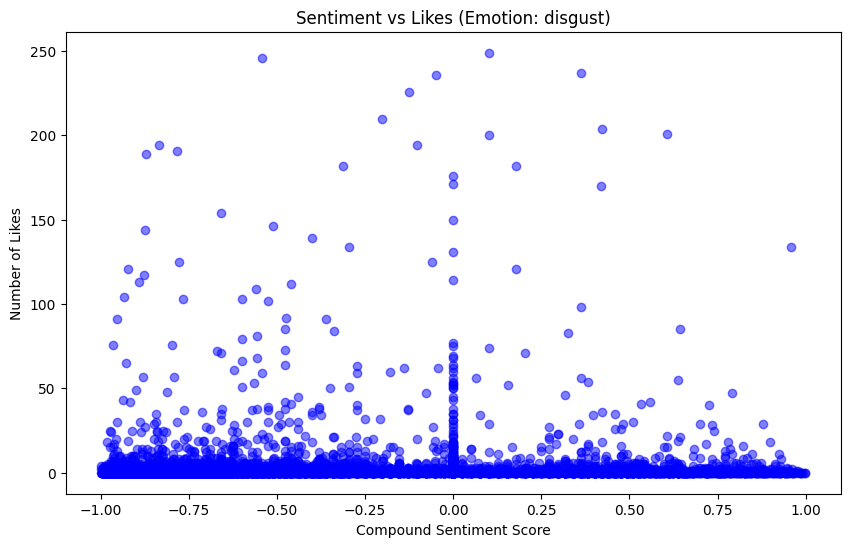

C:\Users\domin\AppData\Local\Temp\ipykernel_28060\1063051609.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered2 = df_filtered[df_comments['emotion'] == emotion]


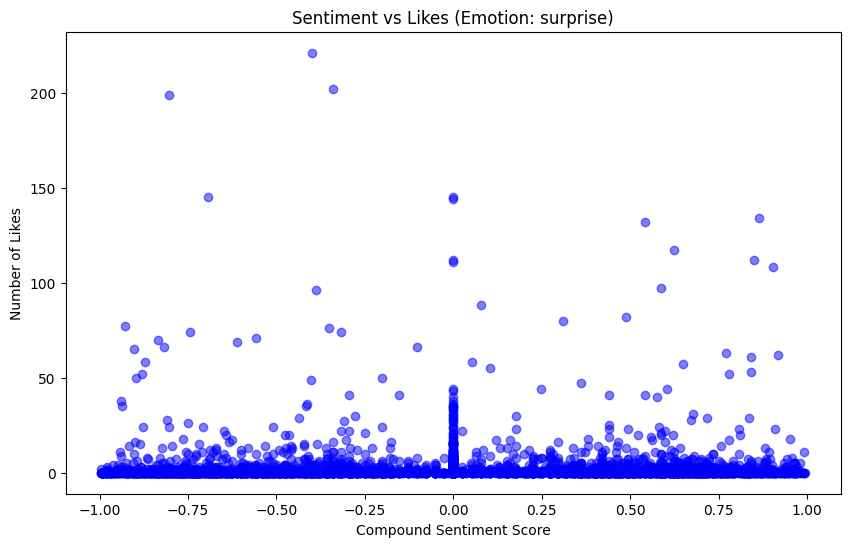

C:\Users\domin\AppData\Local\Temp\ipykernel_28060\1063051609.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered2 = df_filtered[df_comments['emotion'] == emotion]


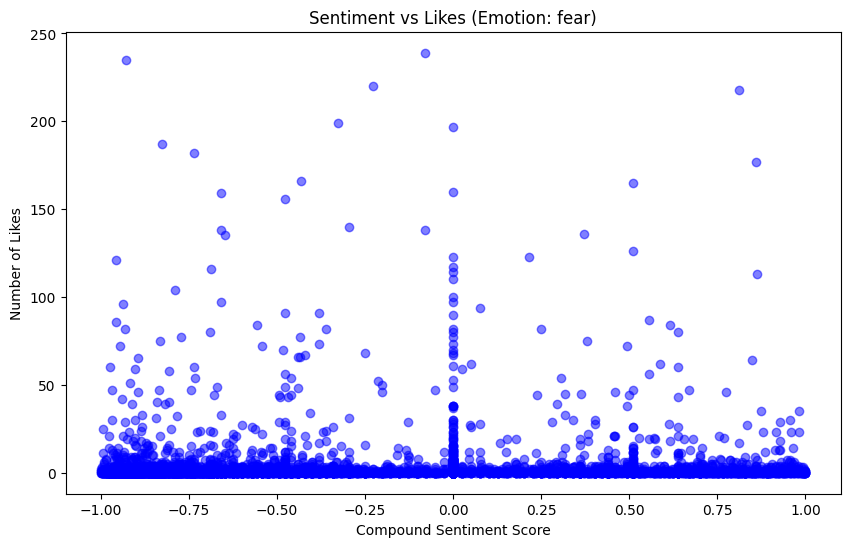

C:\Users\domin\AppData\Local\Temp\ipykernel_28060\1063051609.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered2 = df_filtered[df_comments['emotion'] == emotion]


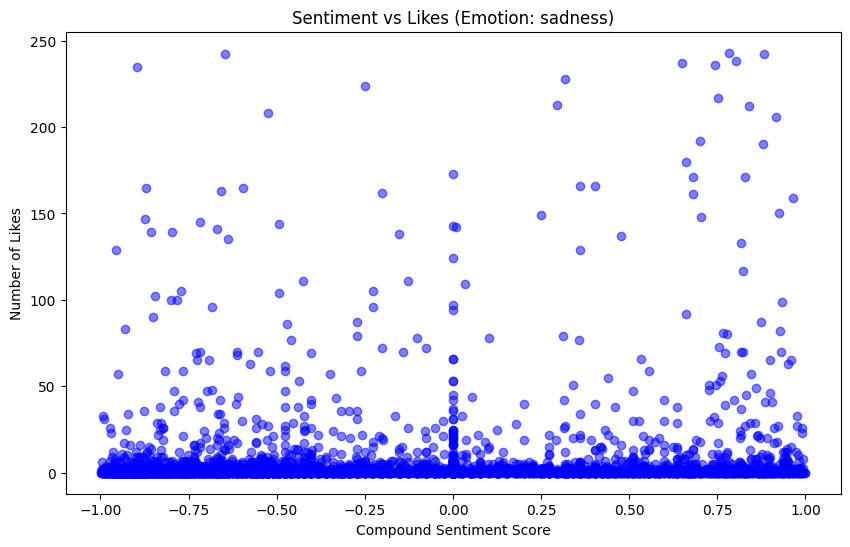

C:\Users\domin\AppData\Local\Temp\ipykernel_28060\1063051609.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered2 = df_filtered[df_comments['emotion'] == emotion]


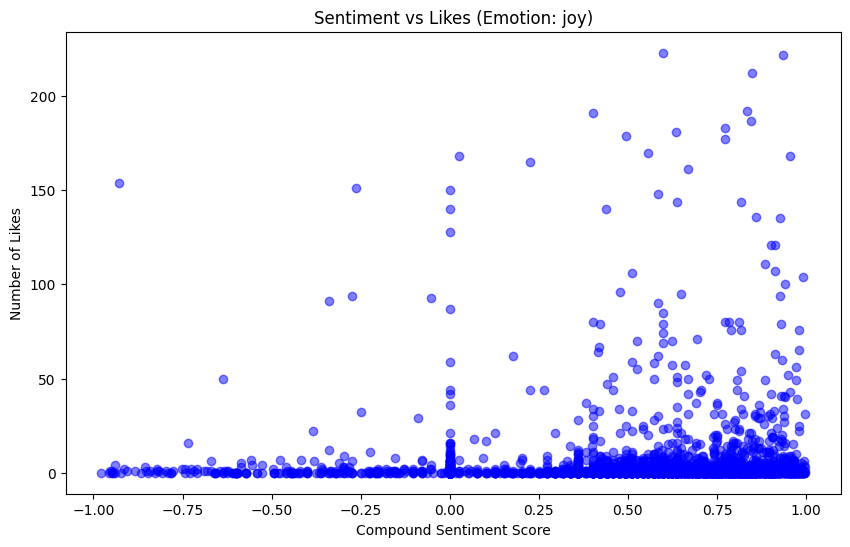

C:\Users\domin\AppData\Local\Temp\ipykernel_28060\1063051609.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered2 = df_filtered[df_comments['emotion'] == emotion]


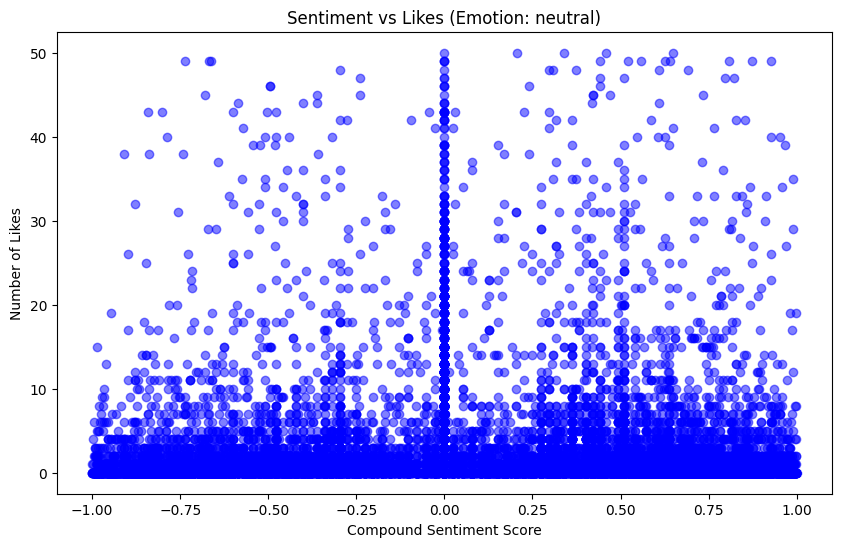

C:\Users\domin\AppData\Local\Temp\ipykernel_28060\1063051609.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered2 = df_filtered[df_comments['emotion'] == emotion]


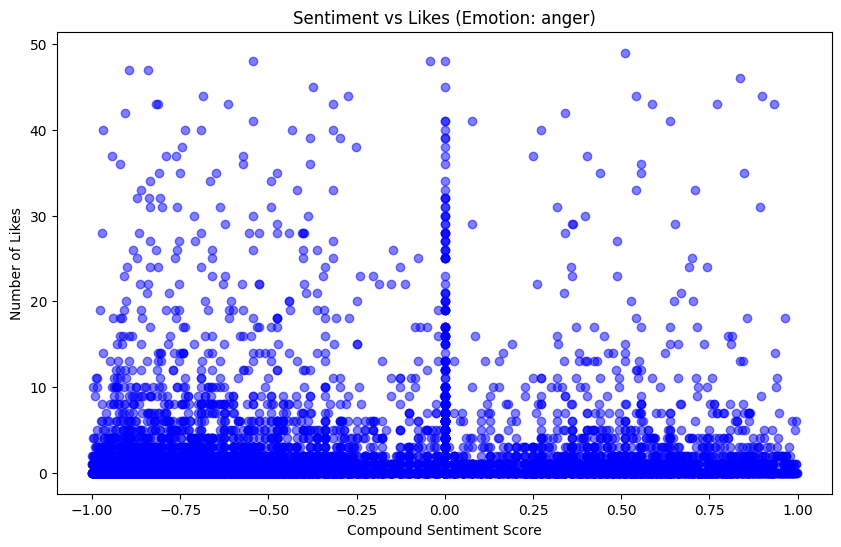

C:\Users\domin\AppData\Local\Temp\ipykernel_28060\1063051609.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered2 = df_filtered[df_comments['emotion'] == emotion]


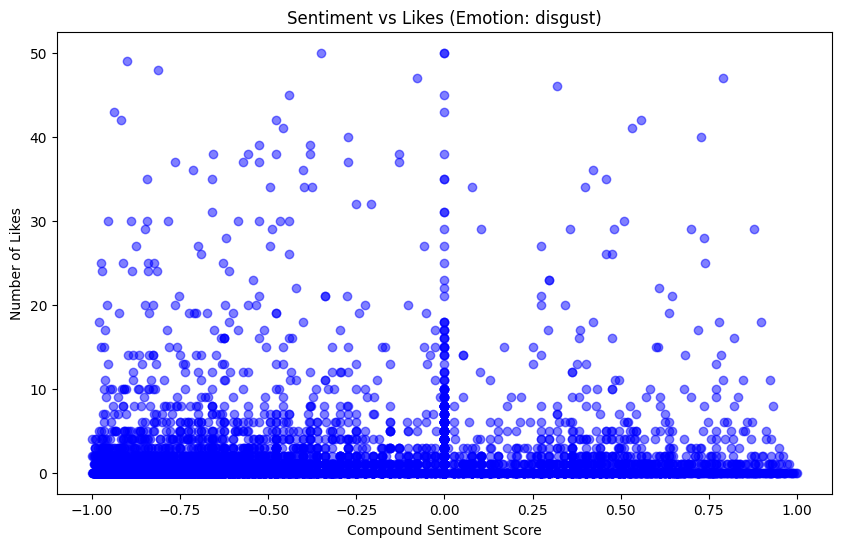

C:\Users\domin\AppData\Local\Temp\ipykernel_28060\1063051609.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered2 = df_filtered[df_comments['emotion'] == emotion]


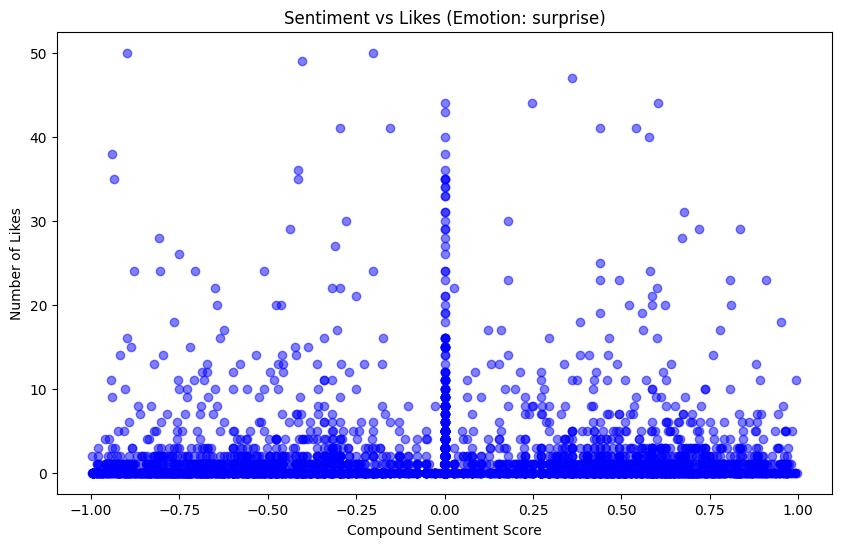

C:\Users\domin\AppData\Local\Temp\ipykernel_28060\1063051609.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered2 = df_filtered[df_comments['emotion'] == emotion]


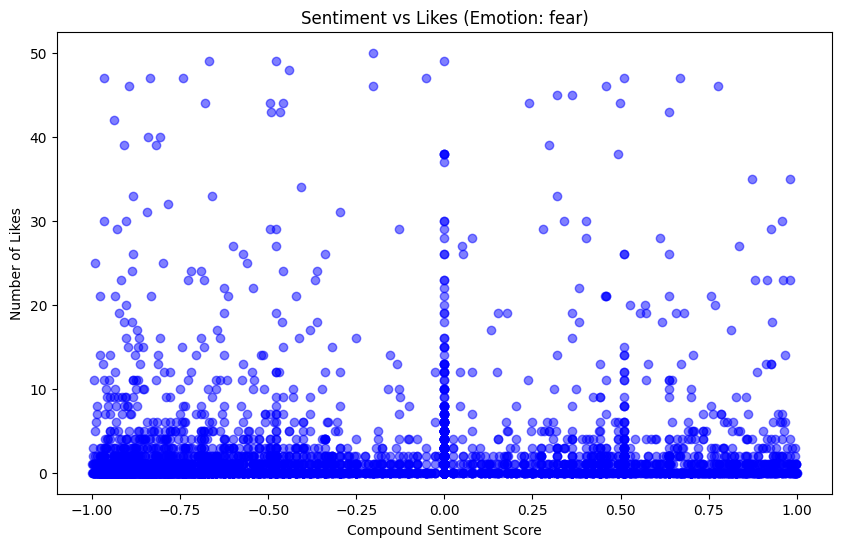

C:\Users\domin\AppData\Local\Temp\ipykernel_28060\1063051609.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered2 = df_filtered[df_comments['emotion'] == emotion]


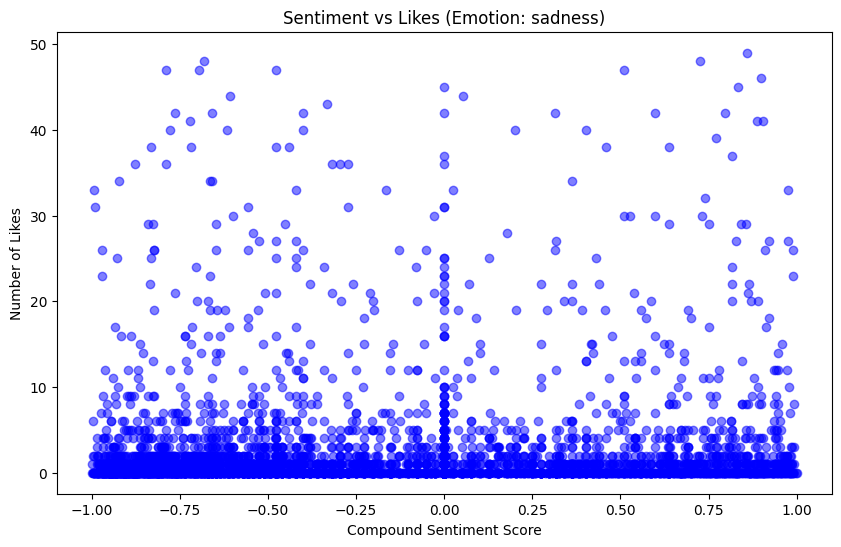

C:\Users\domin\AppData\Local\Temp\ipykernel_28060\1063051609.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered2 = df_filtered[df_comments['emotion'] == emotion]


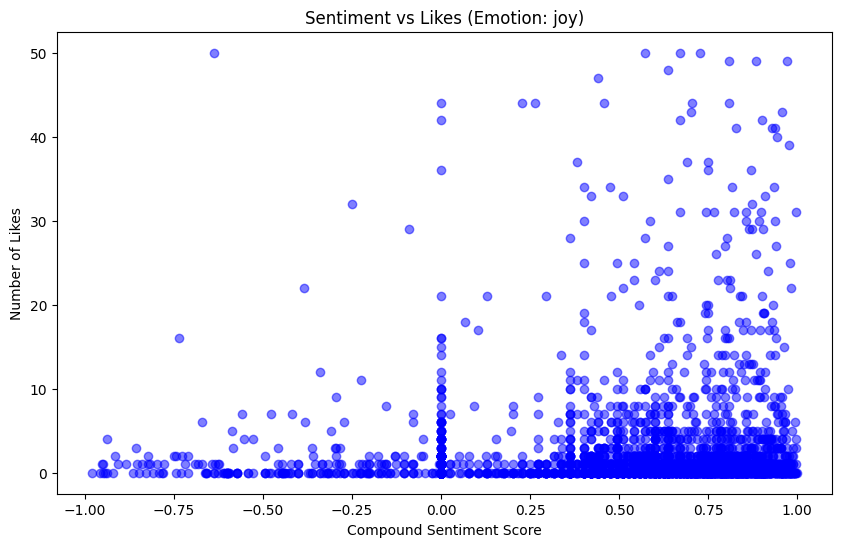

In [ ]:
thresholds = [250, 50]

for num in thresholds:
    # Filter out comments with likes greater than 5000
    df_filtered = df_comments[df_comments['likes'] <= num]

    # Plot emotion vs likes
    for emotion in emotion_counts.index:
        df_filtered2 = df_filtered[df_comments['emotion'] == emotion]
        
        # You can apply a filter based on likes if necessary
        plt.figure(figsize=(10, 6))
        plt.scatter(df_filtered2['compound'], df_filtered2['likes'], alpha=0.5, color='blue')
        plt.title(f'Sentiment vs Likes (Emotion: {emotion})')
        plt.xlabel('Compound Sentiment Score')
        plt.ylabel('Number of Likes')
        plt.show()


Average Likes


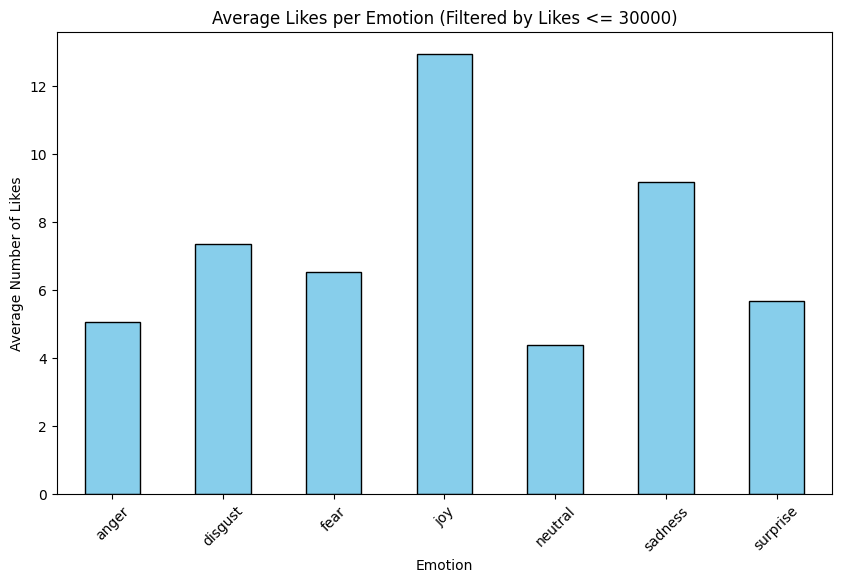

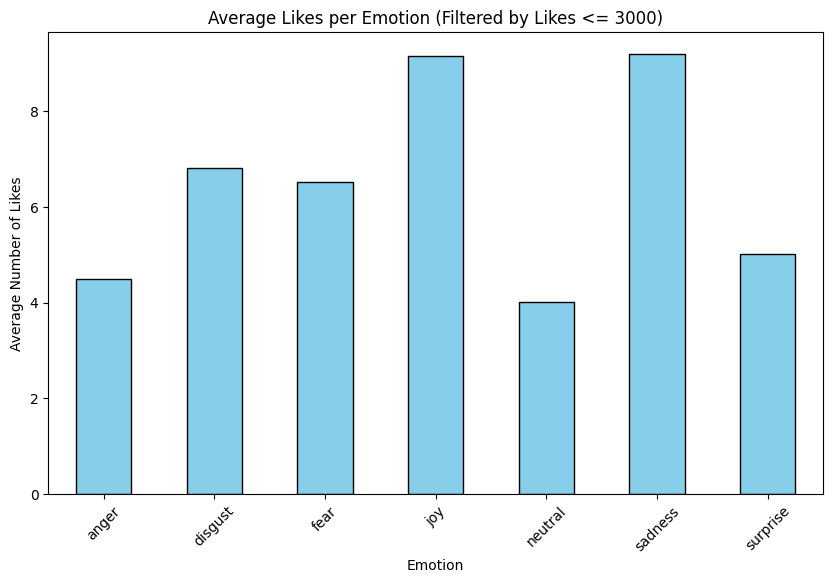

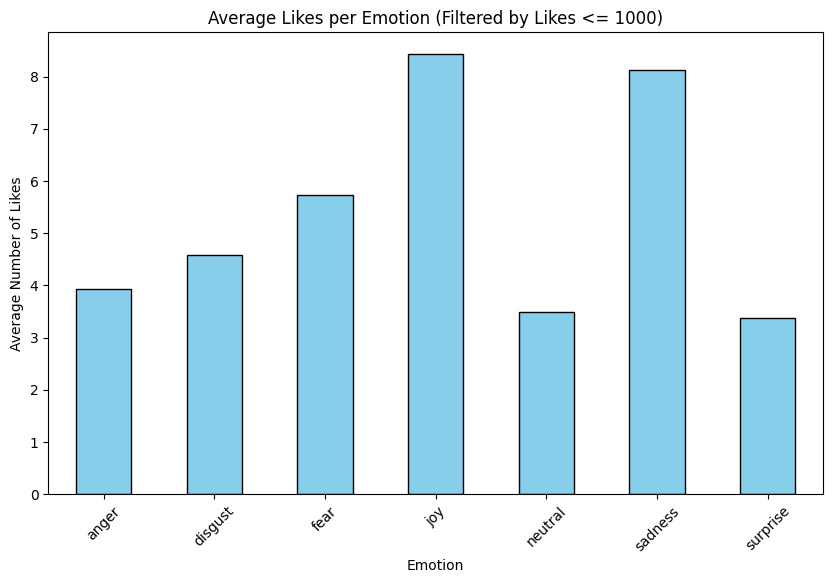

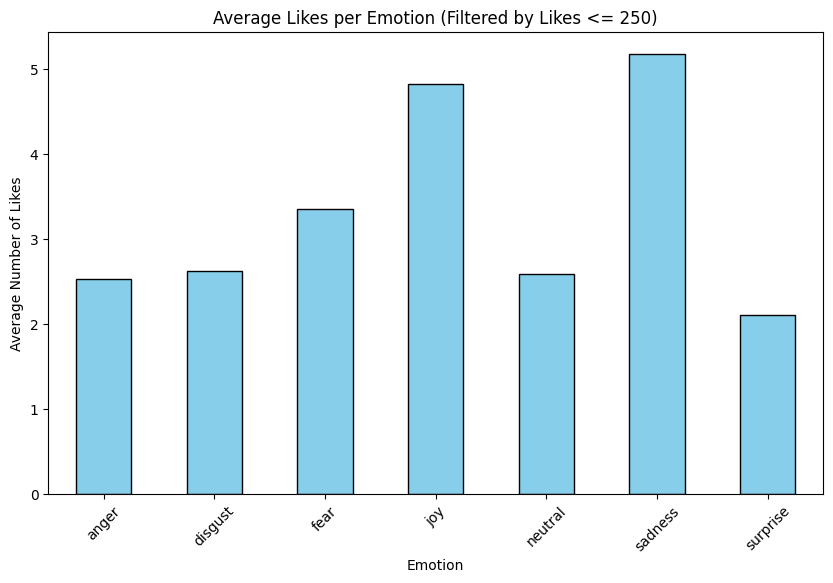

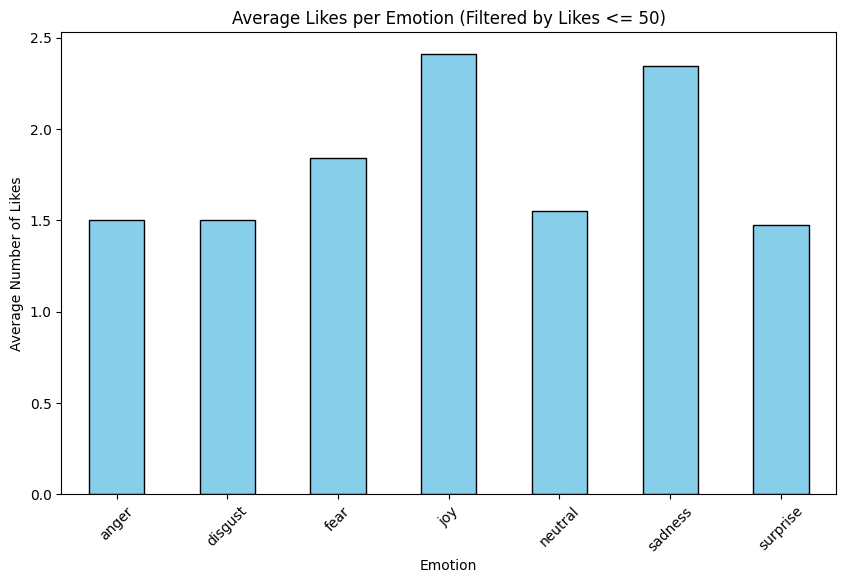

In [ ]:
import matplotlib.pyplot as plt

# Define the thresholds for filtering likes
thresholds = [30000, 3000, 1000, 250, 50]

# Loop through the different thresholds
for num in thresholds:
    # Filter out comments with likes greater than the threshold
    df_filtered = df_comments[df_comments['likes'] <= num]

    # Group by emotion and calculate the average likes for each emotion class
    avg_likes_per_emotion = df_filtered.groupby('emotion')['likes'].mean()

    # Plot the average likes per emotion
    plt.figure(figsize=(10, 6))
    avg_likes_per_emotion.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f'Average Likes per Emotion (Filtered by Likes <= {num})')
    plt.xlabel('Emotion')
    plt.ylabel('Average Number of Likes')
    plt.xticks(rotation=45)
    plt.show()


**Next, we do this by attack rank**


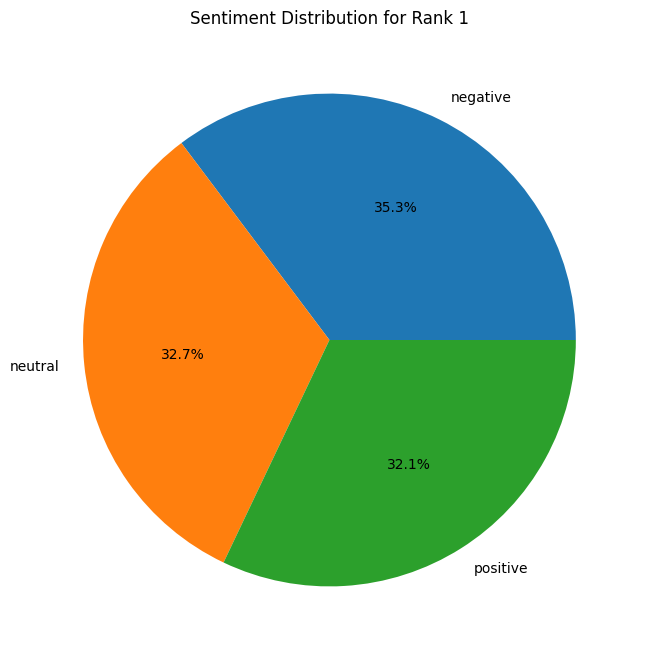

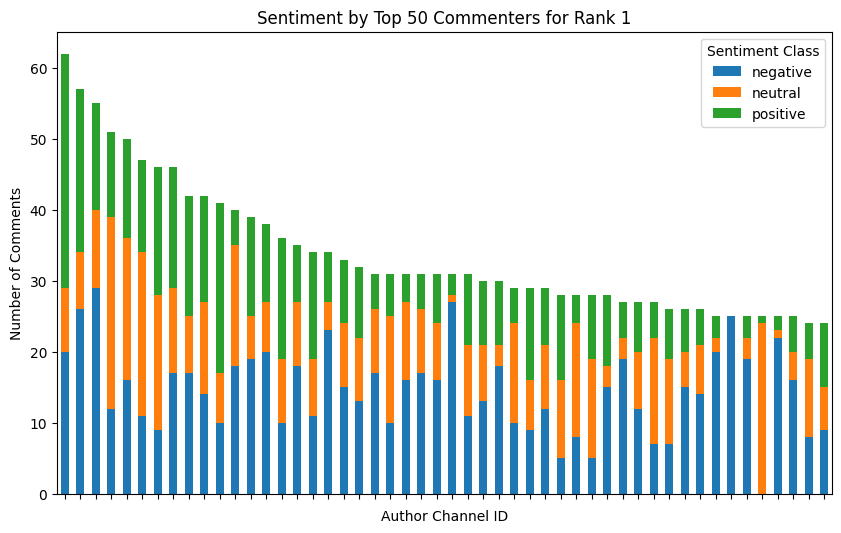

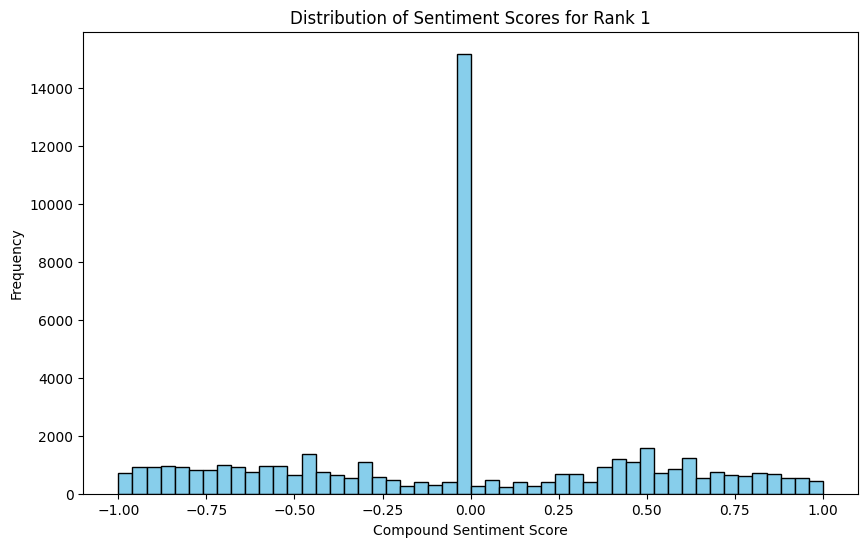

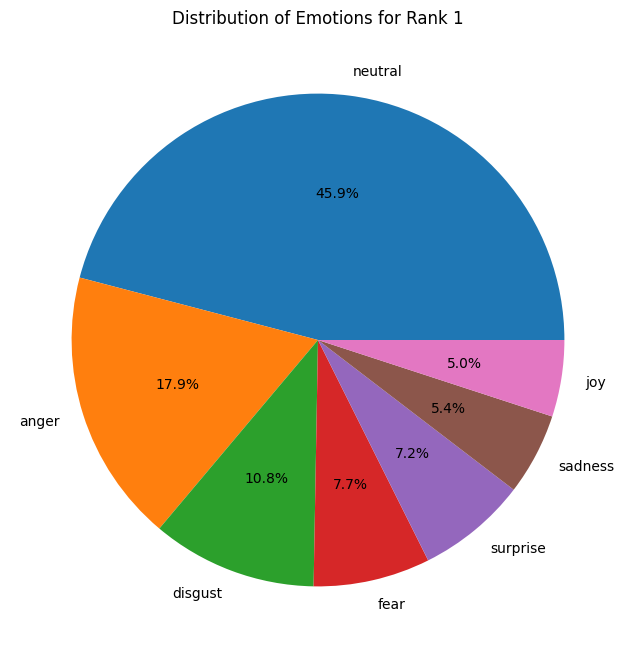

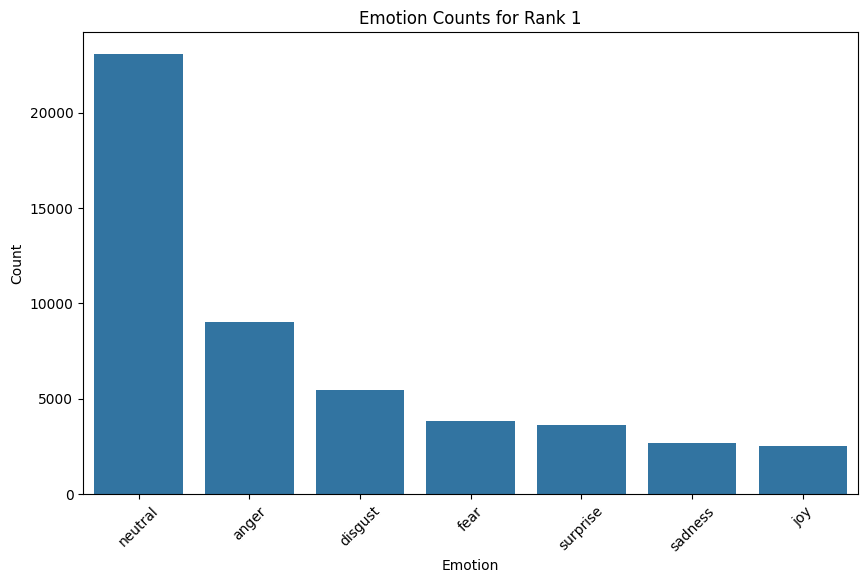

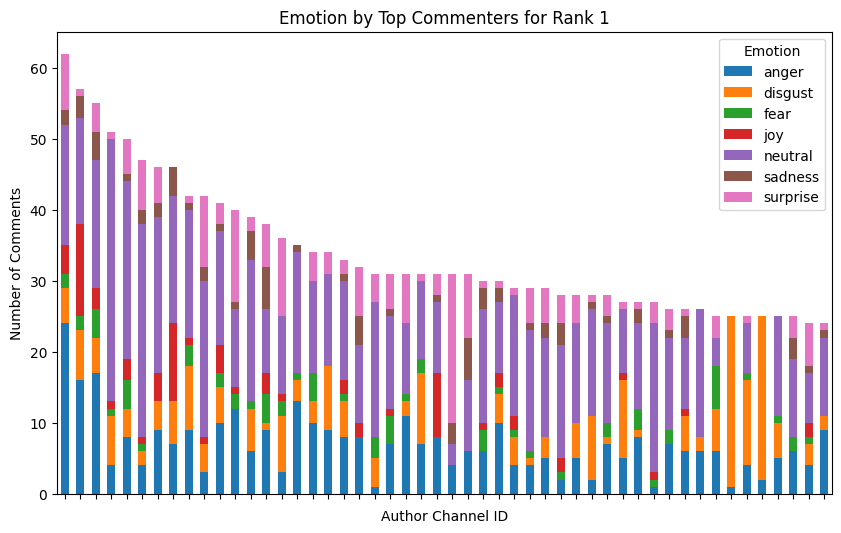

NameError: name 'thresholds' is not defined

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df_comments = pd.read_csv('youtube_comments_final.csv')

# Assuming the ranks are in the 'rank' column
ranks = df_comments['rank'].unique()

# Iterate over each rank
for rank in ranks:
    # Filter the dataframe by the current rank
    df_rank = df_comments[df_comments['rank'] == rank]
    
    # ------------------------ Sentiment Distribution (Pie Chart) ------------------------
    sentiment_counts = df_rank['sentiment_class'].value_counts()
    sentiment_counts.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8))
    plt.title(f'Sentiment Distribution for Rank {rank}')
    plt.ylabel('')
    plt.show()

    # ------------------------ Sentiment by Commenter (Bar Chart) ------------------------
    author_sentiment_counts = df_rank.groupby(['author_channel_id', 'sentiment_class']).size().unstack().fillna(0)
    top_50_authors = df_rank['author_channel_id'].value_counts().head(50).index
    top_authors_sentiment = author_sentiment_counts.loc[top_50_authors]
    ax = top_authors_sentiment.plot(kind='bar', stacked=True, figsize=(10, 6))
    plt.title(f'Sentiment by Top 50 Commenters for Rank {rank}')
    plt.xlabel('Author Channel ID')
    plt.ylabel('Number of Comments')
    plt.legend(title='Sentiment Class')
    plt.xticks(ticks=range(len(top_50_authors)), labels=[], rotation=0)
    plt.show()

    # ------------------------ Sentiment Score Distribution (Histogram) ------------------------
    df_rank['compound'].plot(kind='hist', bins=50, color='skyblue', edgecolor='black', figsize=(10, 6))
    plt.title(f'Distribution of Sentiment Scores for Rank {rank}')
    plt.xlabel('Compound Sentiment Score')
    plt.ylabel('Frequency')
    plt.show()

    # ------------------------ Emotion Distribution (Pie Chart) ------------------------
    emotion_counts = df_rank['emotion'].value_counts()
    plt.figure(figsize=(8, 8))
    emotion_counts.plot(kind='pie', autopct='%1.1f%%', legend=False)
    plt.title(f'Distribution of Emotions for Rank {rank}')
    plt.ylabel('')
    plt.show()

    # ------------------------ Emotion Counts (Bar Plot) ------------------------
    plt.figure(figsize=(10, 6))
    sns.barplot(x=emotion_counts.index, y=emotion_counts.values)
    plt.title(f'Emotion Counts for Rank {rank}')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

    # ------------------------ Emotion by Commenter (Bar Chart) ------------------------
    author_emotion_counts = df_rank.groupby(['author_channel_id', 'emotion']).size().unstack().fillna(0)
    top_authors_emotion = author_emotion_counts.loc[top_50_authors]
    ax = top_authors_emotion.plot(kind='bar', stacked=True, figsize=(10, 6))
    plt.title(f'Emotion by Top Commenters for Rank {rank}')
    plt.xlabel('Author Channel ID')
    plt.ylabel('Number of Comments')
    plt.legend(title='Emotion')
    plt.xticks(ticks=range(len(top_50_authors)), labels=[], rotation=0)
    plt.show()

    # ------------------------ Average Likes per Emotion ------------------------
    for num in thresholds:
        df_filtered = df_rank[df_rank['likes'] <= num]
        avg_likes_per_emotion = df_filtered.groupby('emotion')['likes'].mean()
        plt.figure(figsize=(10, 6))
        avg_likes_per_emotion.plot(kind='bar', color='skyblue', edgecolor='black')
        plt.title(f'Average Likes per Emotion (Rank {rank}, Likes <= {num})')
        plt.xlabel('Emotion')
        plt.ylabel('Average Number of Likes')
        plt.xticks(rotation=45)
        plt.show()


Next, we want to augment this to save each figure into a folder as they are created.

But before that, want to solidify which figures we want

The stuff about likes should maybe be another figure

And also, will need to properly get rid of outliers for certain things so not just trying bunch of thresholds...


**FINAL PAPER VISUALIZATIONS**


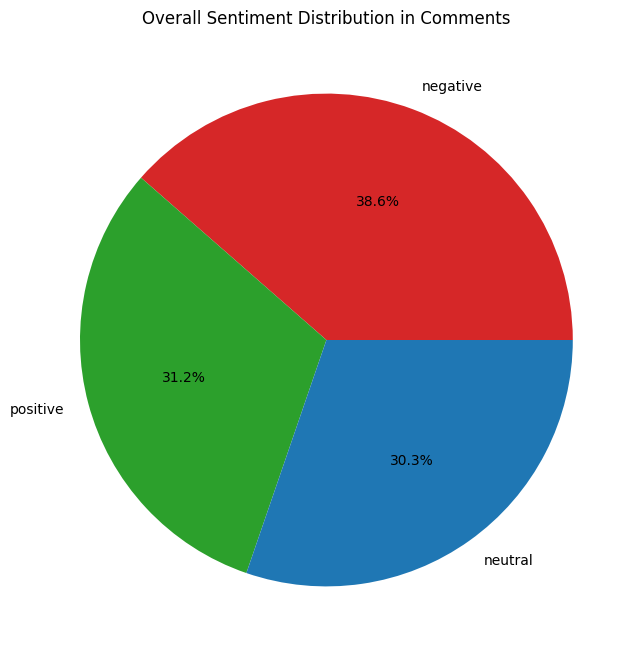

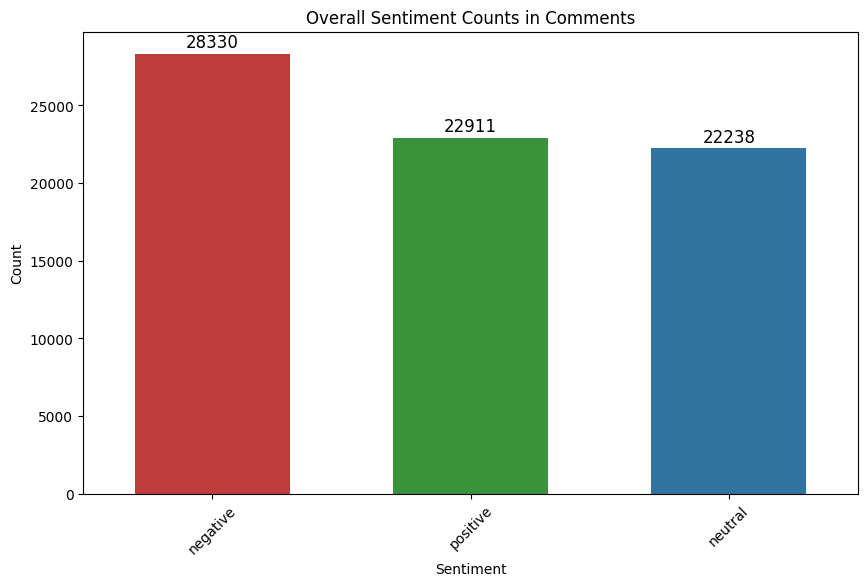

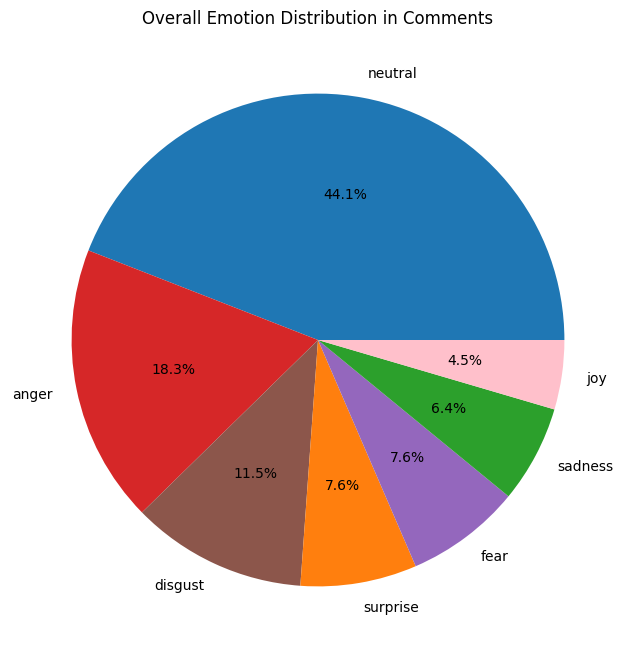

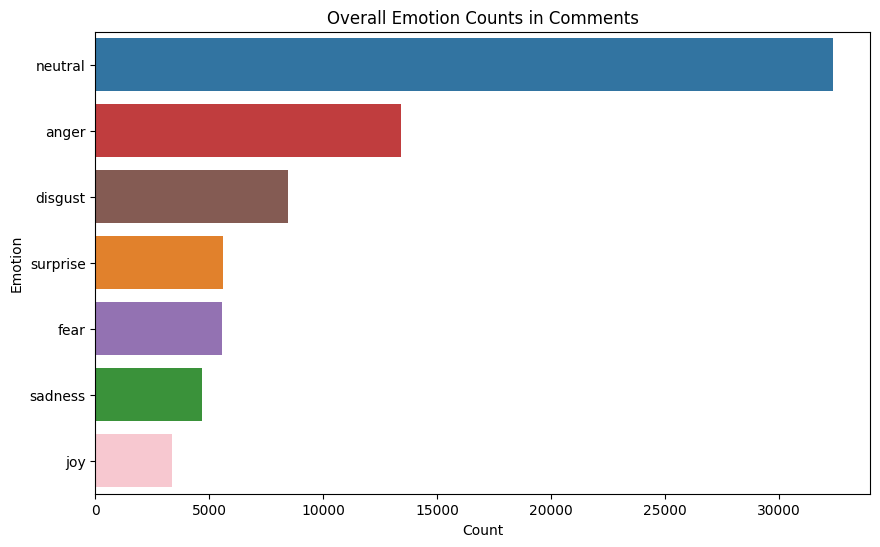

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a fixed color mapping for sentiment
color_mapping = {'positive': '#2ca02c', 'neutral': '#1f77b4', 'negative': '#d62728'}  # Green, Blue, Red

# Define a fixed color mapping for emotions
emotion_color_mapping = {
    'joy': 'pink',       # Pink
    'sadness': '#2ca02c',   # Green
    'anger': '#d62728',     # Red
    'surprise': '#ff7f0e',  # Orange
    'fear': '#9467bd',      # Purple
    'disgust': '#8c564b',   # Brown
    'neutral': '#1f77b4'    # Blue
}

# --- For Sentiment ---
# Ensure the order is consistent
sentiment_counts = df_comments['sentiment_class'].value_counts()
colors = [color_mapping[label] for label in sentiment_counts.index]

# --- Plot the Pie Chart ---
plt.figure(figsize=(8, 8))
sentiment_counts.plot(kind='pie', autopct='%1.1f%%', colors=colors, legend=False)
plt.title('Overall Sentiment Distribution in Comments')
plt.ylabel('')
plt.show()

# --- Plot the Bar Plot with Numbers and Thinner Bars ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=colors, width=0.6, hue=sentiment_counts.index)  # Thinner bars and color palette
plt.title('Overall Sentiment Counts in Comments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Add numbers on top of the bars (without decimals)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 8), textcoords='offset points')

plt.show()

# --- For Emotions ---
# Ensure the order is consistent for emotions
emotion_counts = df_comments['emotion'].value_counts()
colors = [emotion_color_mapping[label] for label in emotion_counts.index]

# --- Plot the Pie Chart ---
plt.figure(figsize=(8, 8))
emotion_counts.plot(kind='pie', autopct='%1.1f%%', colors=colors, legend=False)
plt.title('Overall Emotion Distribution in Comments')
plt.ylabel('')  
plt.show()

# --- Plot the Bar Plot with Horizontal Bars and Correct Colors ---
plt.figure(figsize=(10, 6))
sns.barplot(y=emotion_counts.index, x=emotion_counts.values, palette=colors, hue=emotion_counts.index)  # Horizontal bars
plt.title('Overall Emotion Counts in Comments')
plt.xlabel('Count')
plt.ylabel('Emotion')
plt.show()


_Overall, one plot_


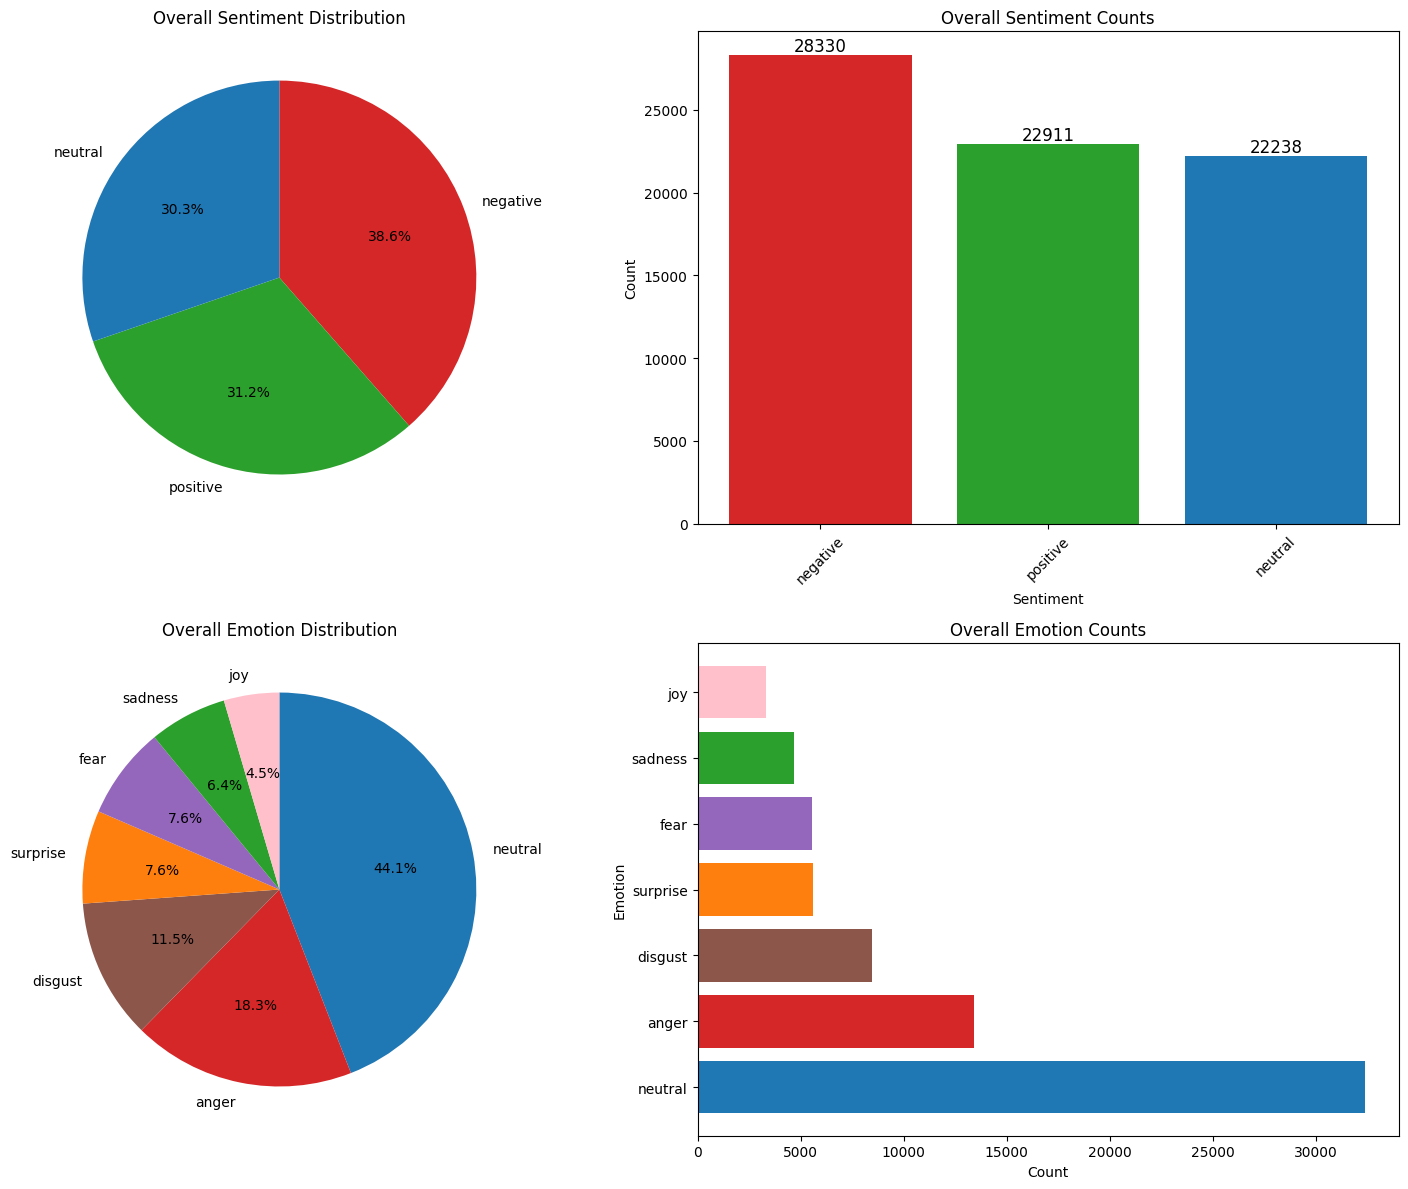

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a fixed color mapping for sentiment
color_mapping = {'positive': '#2ca02c', 'neutral': '#1f77b4', 'negative': '#d62728'}  # Green, Blue, Red

# Define a fixed color mapping for emotions
emotion_color_mapping = {
    'joy': 'pink',       # Pink
    'sadness': '#2ca02c',   # Green
    'anger': '#d62728',     # Red
    'surprise': '#ff7f0e',  # Orange
    'fear': '#9467bd',      # Purple
    'disgust': '#8c564b',   # Brown
    'neutral': '#1f77b4'    # Blue
}

# Sentiment counts
sentiment_counts = df_comments['sentiment_class'].value_counts()
sentiment_colors = [color_mapping[label] for label in sentiment_counts.index]

# Emotion counts
emotion_counts = df_comments['emotion'].value_counts()
emotion_colors = [emotion_color_mapping[label] for label in emotion_counts.index]

# Create a 2x2 grid for subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))  # Adjust the size as needed

# ------------------------ Sentiment Distribution (Pie Chart) ------------------------
axes[0, 0].pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=sentiment_colors, startangle=90, counterclock=False)
axes[0, 0].set_title('Overall Sentiment Distribution')

# ------------------------ Sentiment Counts (Bar Plot) ------------------------
axes[0, 1].bar(sentiment_counts.index, sentiment_counts.values, color=sentiment_colors)
axes[0, 1].set_title('Overall Sentiment Counts')
axes[0, 1].set_xlabel('Sentiment')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=45)

# Add numbers on top of the bars (without decimals)
for i, value in enumerate(sentiment_counts.values):
    axes[0, 1].text(i, value + 0.5, str(int(value)), ha='center', va='bottom', fontsize=12)

# ------------------------ Emotion Distribution (Pie Chart) ------------------------
axes[1, 0].pie(emotion_counts, labels=emotion_counts.index, autopct='%1.1f%%', colors=emotion_colors, startangle=90, counterclock=False)
axes[1, 0].set_title('Overall Emotion Distribution')

# ------------------------ Emotion Counts (Bar Plot) ------------------------
axes[1, 1].barh(emotion_counts.index, emotion_counts.values, color=emotion_colors)
axes[1, 1].set_title('Overall Emotion Counts')
axes[1, 1].set_xlabel('Count')
axes[1, 1].set_ylabel('Emotion')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


_Rank by Rank_ (Separate)


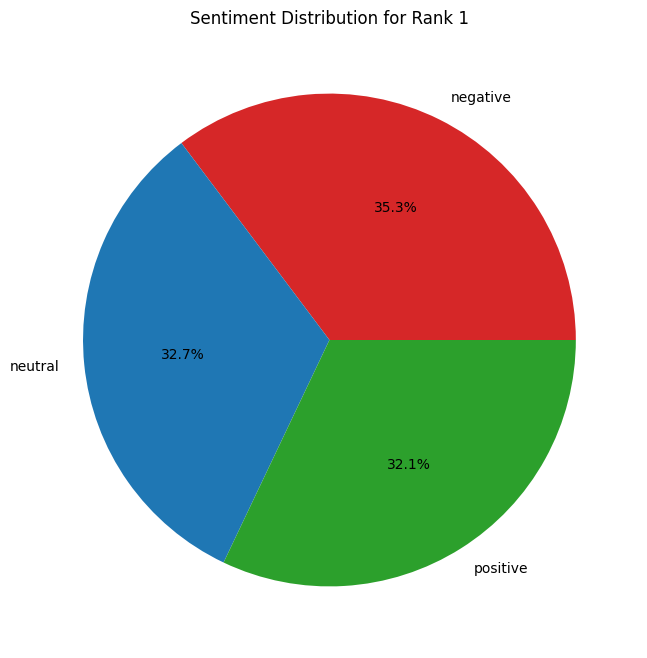

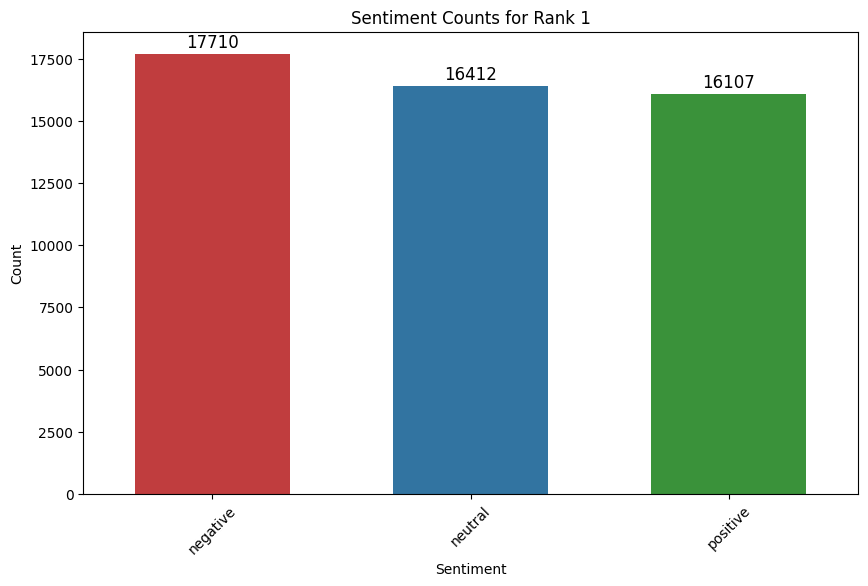

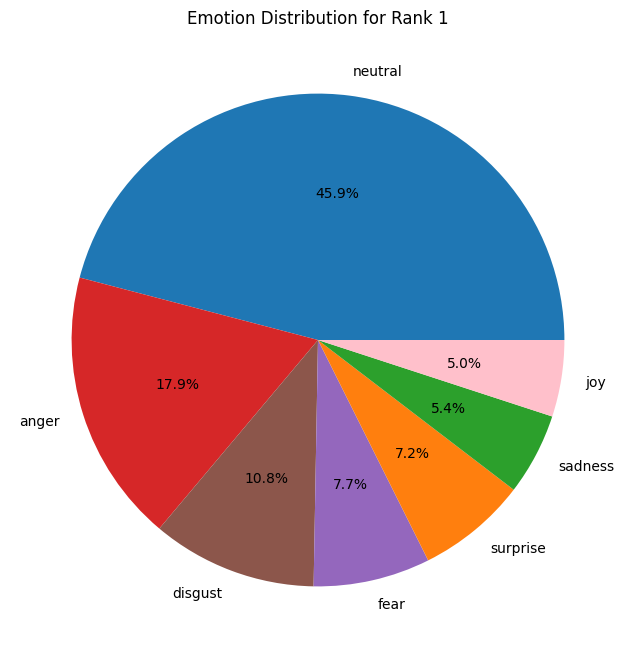

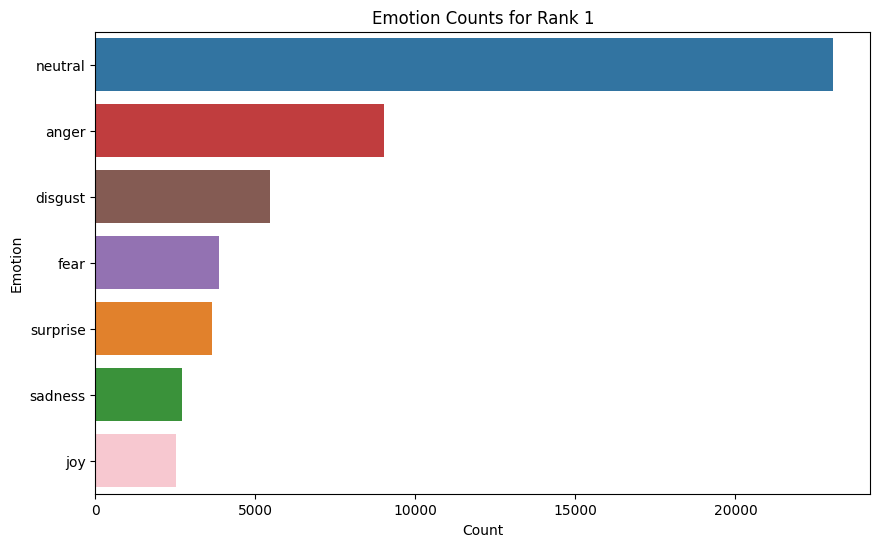

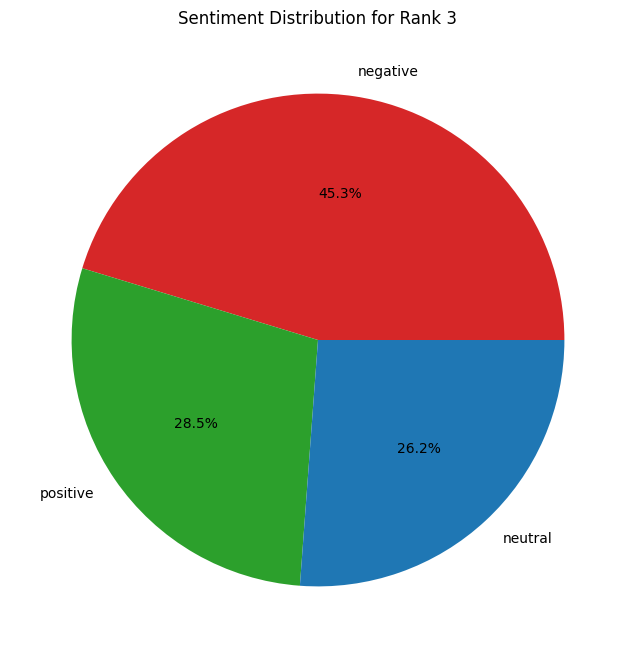

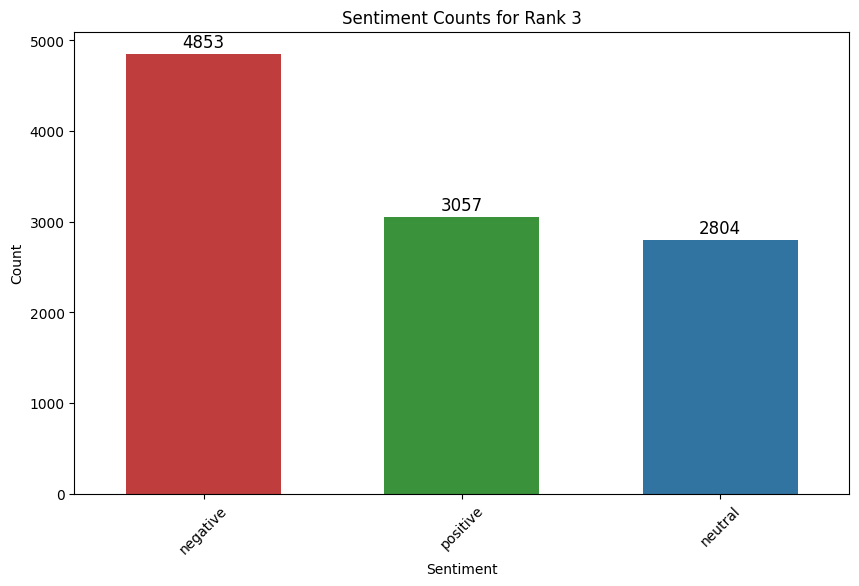

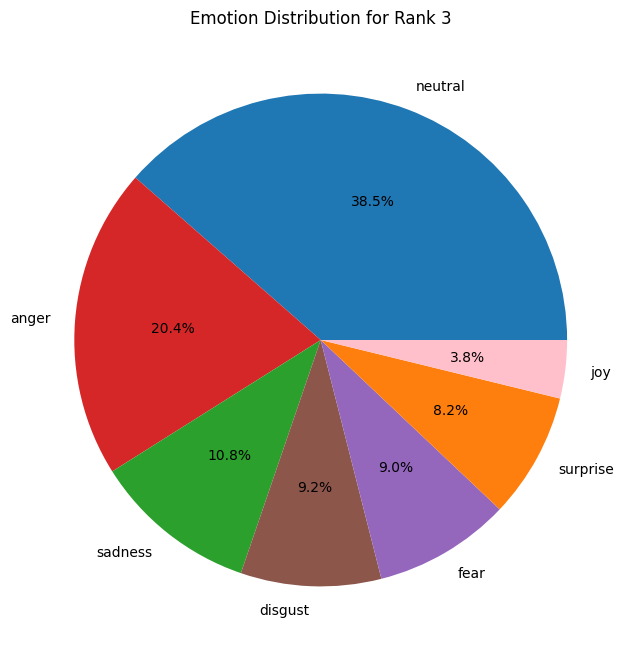

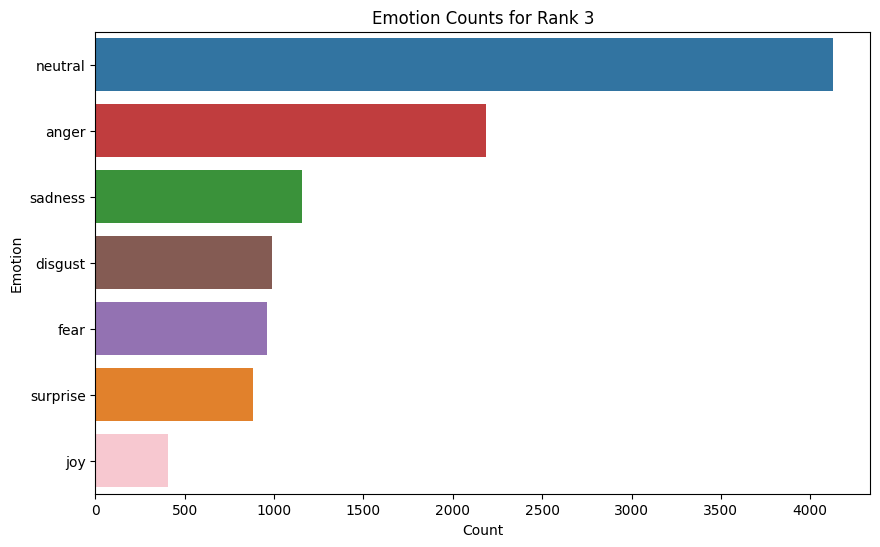

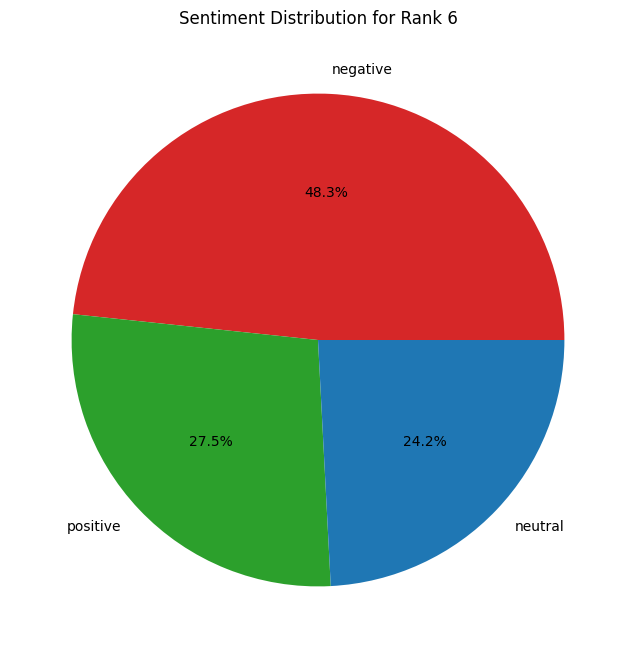

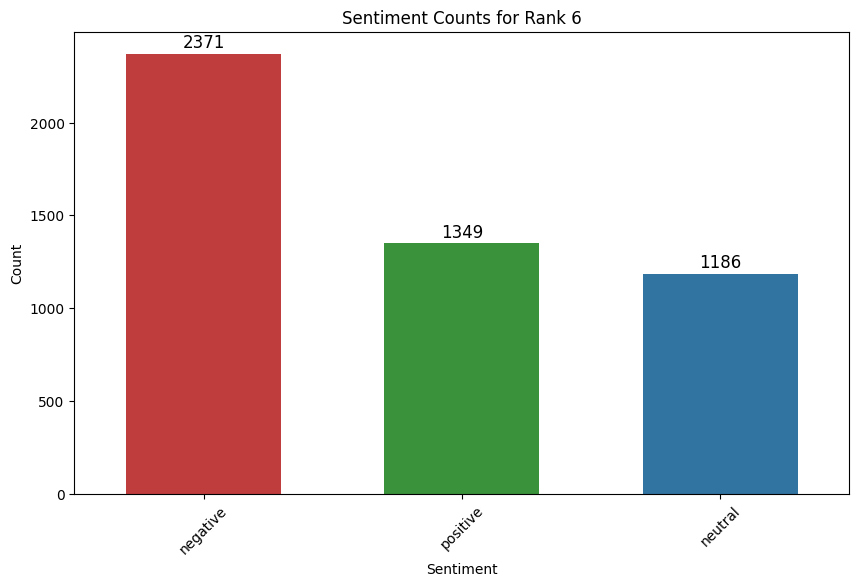

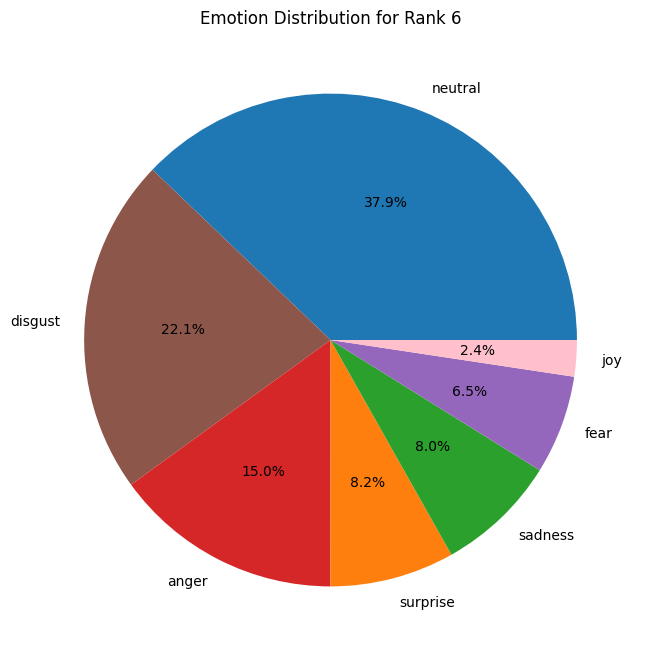

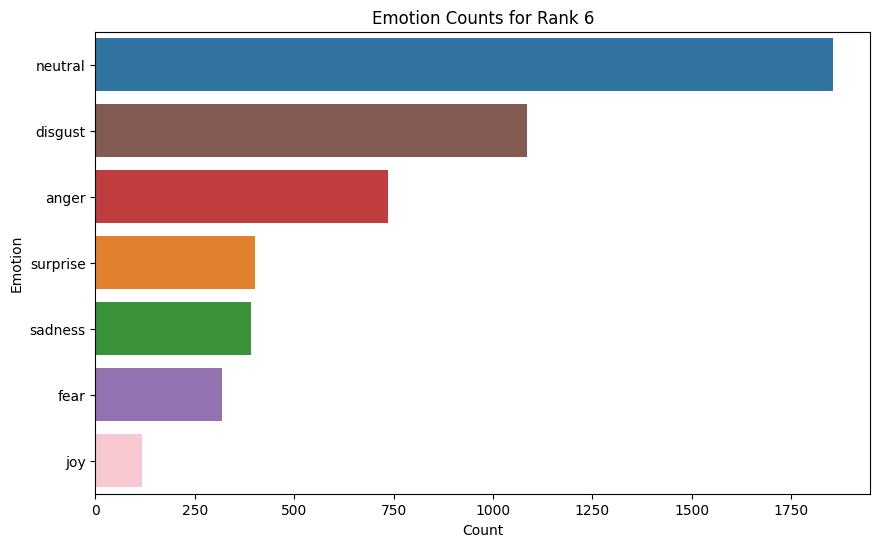

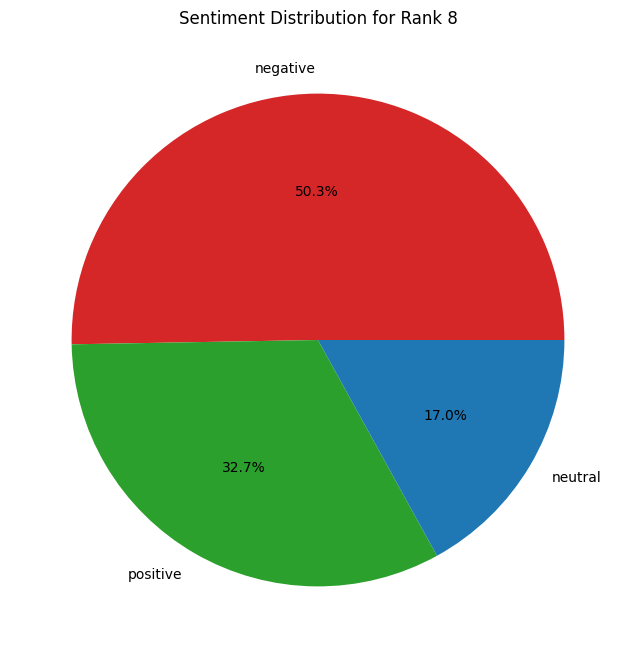

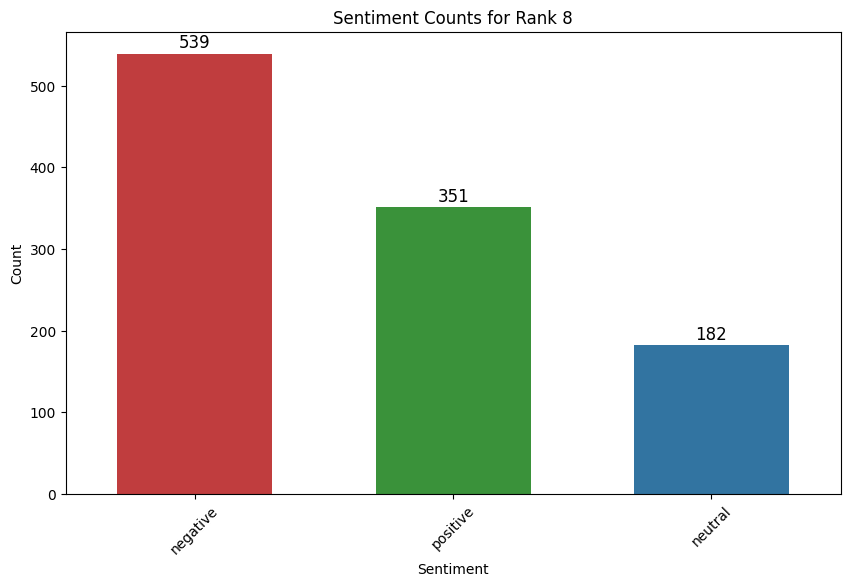

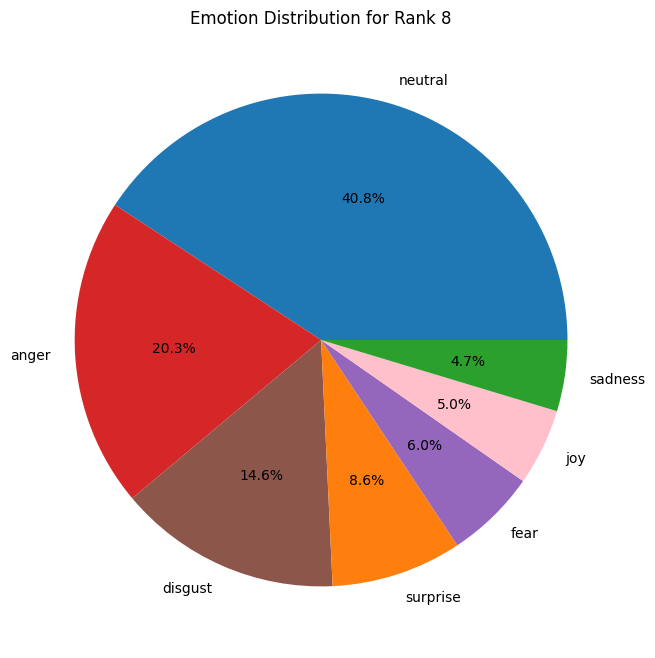

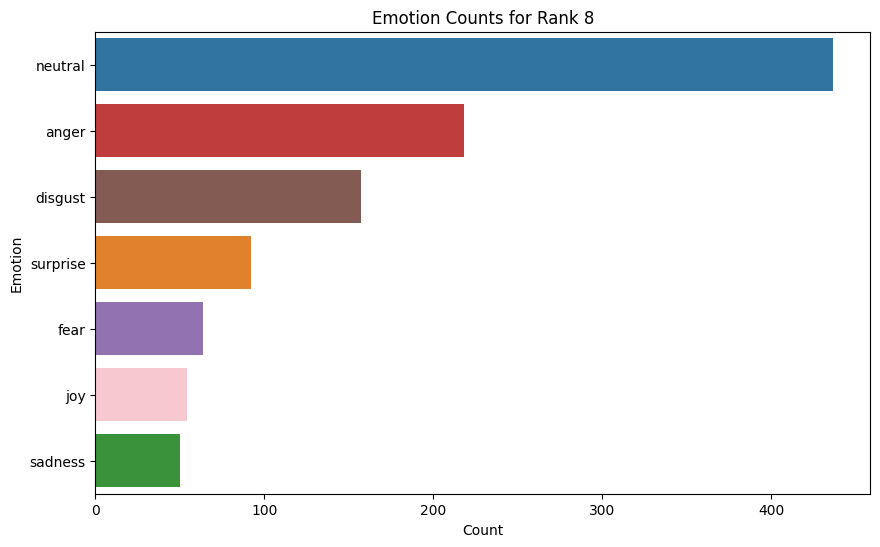

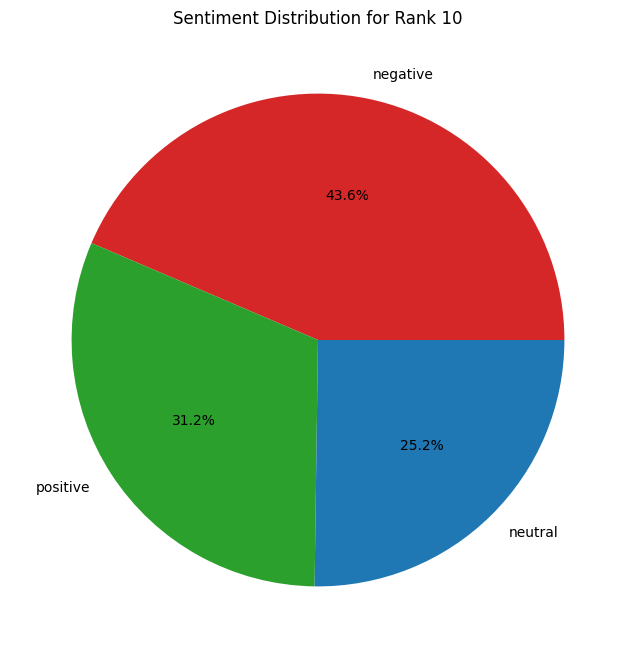

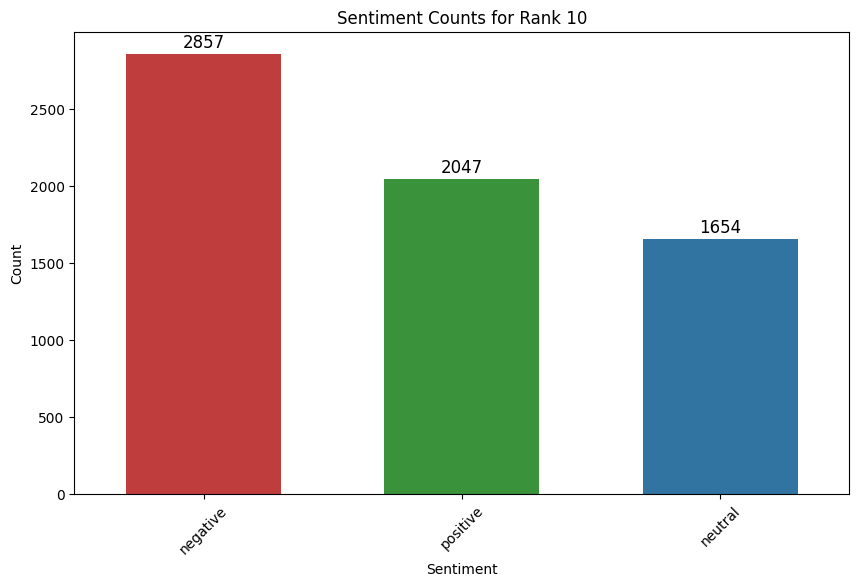

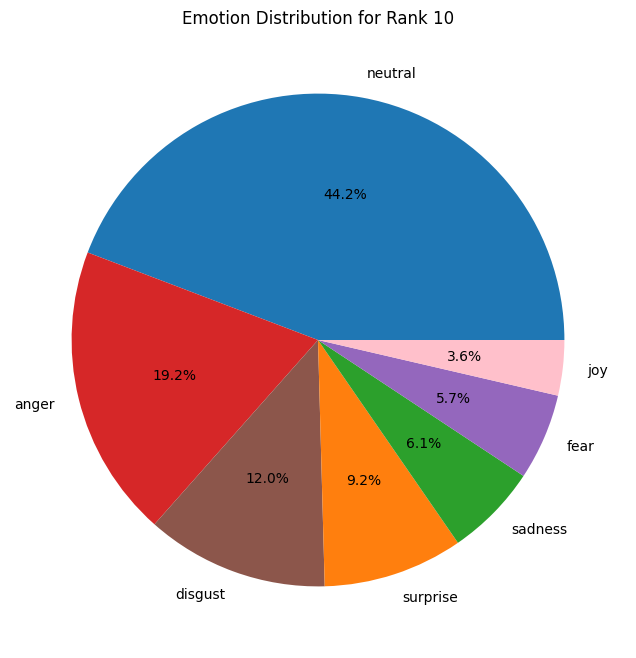

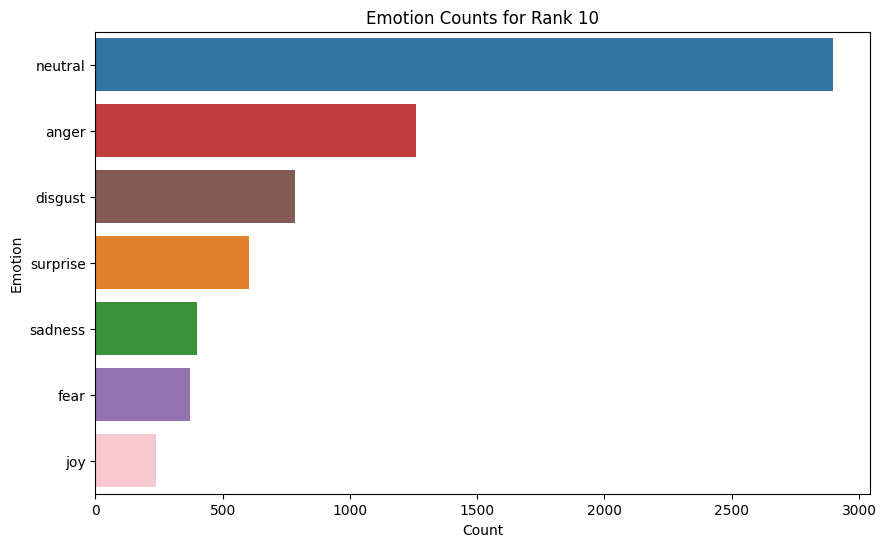

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a fixed color mapping for sentiment
color_mapping = {'positive': '#2ca02c', 'neutral': '#1f77b4', 'negative': '#d62728'}  # Green, Blue, Red

# Define a fixed color mapping for emotions
emotion_color_mapping = {
    'joy': 'pink',       # Pink
    'sadness': '#2ca02c',   # Green
    'anger': '#d62728',     # Red
    'surprise': '#ff7f0e',  # Orange
    'fear': '#9467bd',      # Purple
    'disgust': '#8c564b',   # Brown
    'neutral': '#1f77b4'    # Blue
}

# Define ranks (example)
ranks = df_comments['rank'].unique()

# Iterate over each rank
for rank in ranks:
    # Filter the dataframe by the current rank
    df_rank = df_comments[df_comments['rank'] == rank]
    
    # ------------------------ Sentiment Distribution (Pie Chart) ------------------------
    sentiment_counts = df_rank['sentiment_class'].value_counts()
    colors = [color_mapping[label] for label in sentiment_counts.index]

    # Plot the Pie Chart
    plt.figure(figsize=(8, 8))
    sentiment_counts.plot(kind='pie', autopct='%1.1f%%', colors=colors, legend=False)
    plt.title(f'Sentiment Distribution for Rank {rank}')
    plt.ylabel('')
    plt.show()

    # ------------------------ Sentiment Counts (Bar Plot) ------------------------
    # Plot the Bar Plot with Numbers and Thinner Bars
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=colors, width=0.6, hue=sentiment_counts.index)  # Thinner bars
    plt.title(f'Sentiment Counts for Rank {rank}')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

    # Add numbers on top of the bars (without decimals)
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=12, color='black', xytext=(0, 8), textcoords='offset points')

    plt.show()

    # ------------------------ Emotion Distribution (Pie Chart) ------------------------
    emotion_counts = df_rank['emotion'].value_counts()
    colors = [emotion_color_mapping[label] for label in emotion_counts.index]

    # Plot the Pie Chart
    plt.figure(figsize=(8, 8))
    emotion_counts.plot(kind='pie', autopct='%1.1f%%', colors=colors, legend=False)
    plt.title(f'Emotion Distribution for Rank {rank}')
    plt.ylabel('')
    plt.show()

    # ------------------------ Emotion Counts (Bar Plot) ------------------------
    # Plot the Bar Plot with Horizontal Bars and Correct Colors
    plt.figure(figsize=(10, 6))
    sns.barplot(y=emotion_counts.index, x=emotion_counts.values, palette=colors, hue=emotion_counts.index)  # Horizontal bars
    plt.title(f'Emotion Counts for Rank {rank}')
    plt.xlabel('Count')
    plt.ylabel('Emotion')
    plt.show()


_Plots within Ranks Combined_


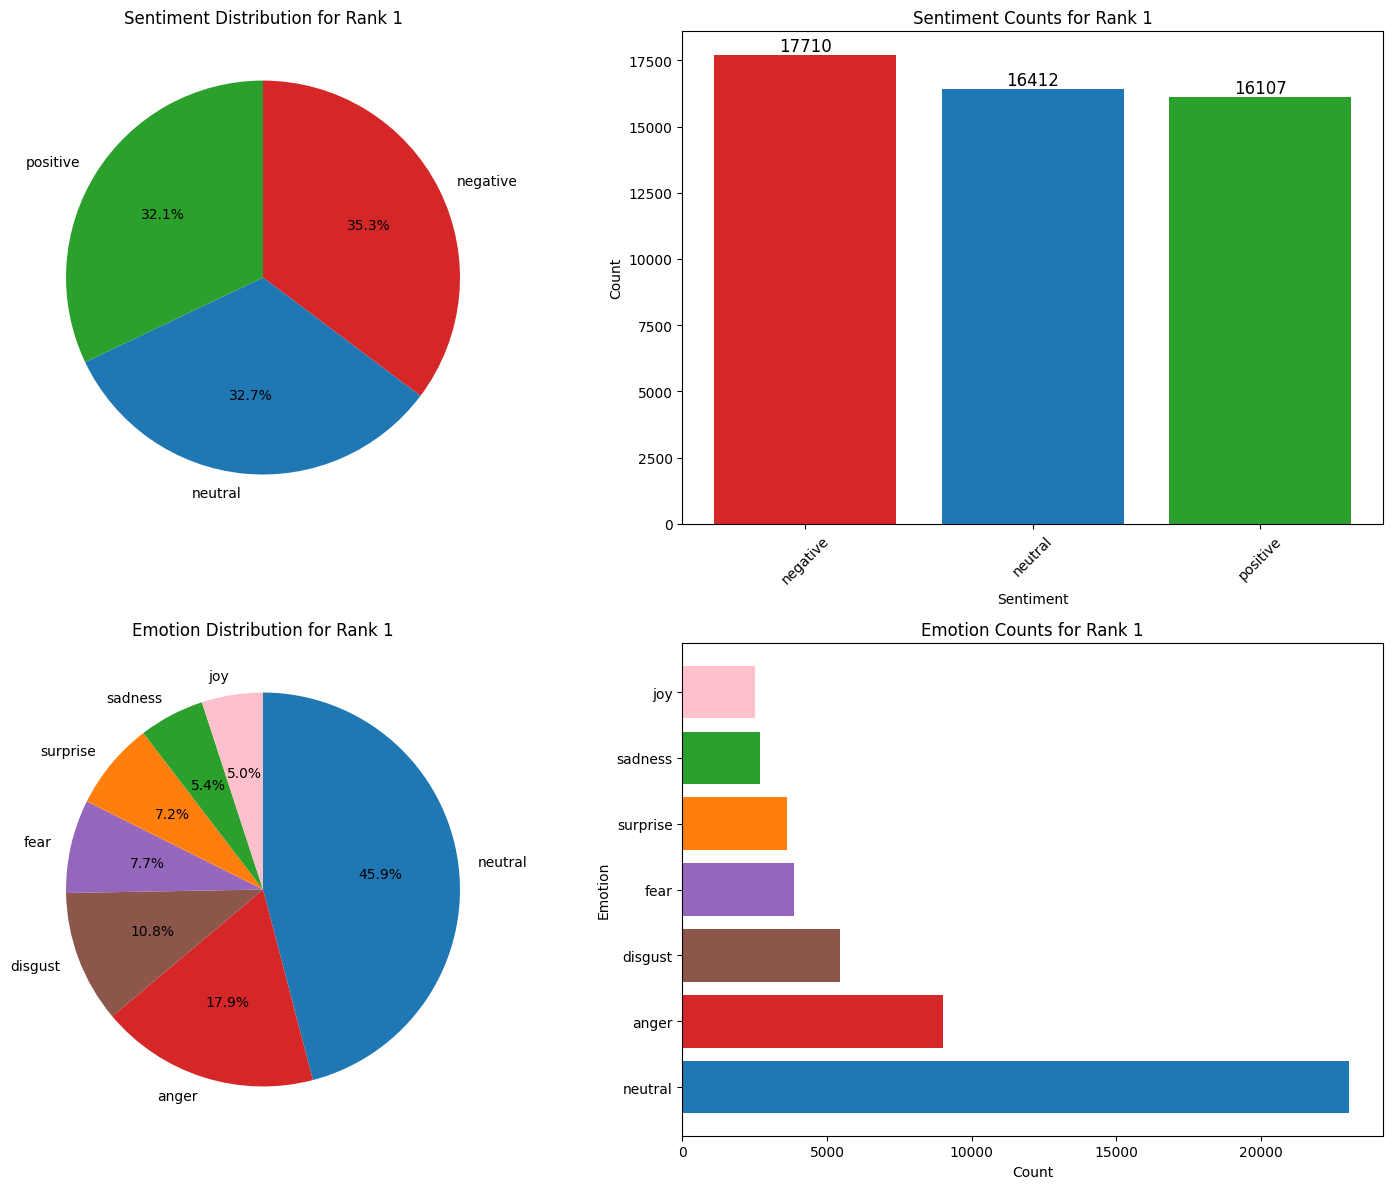

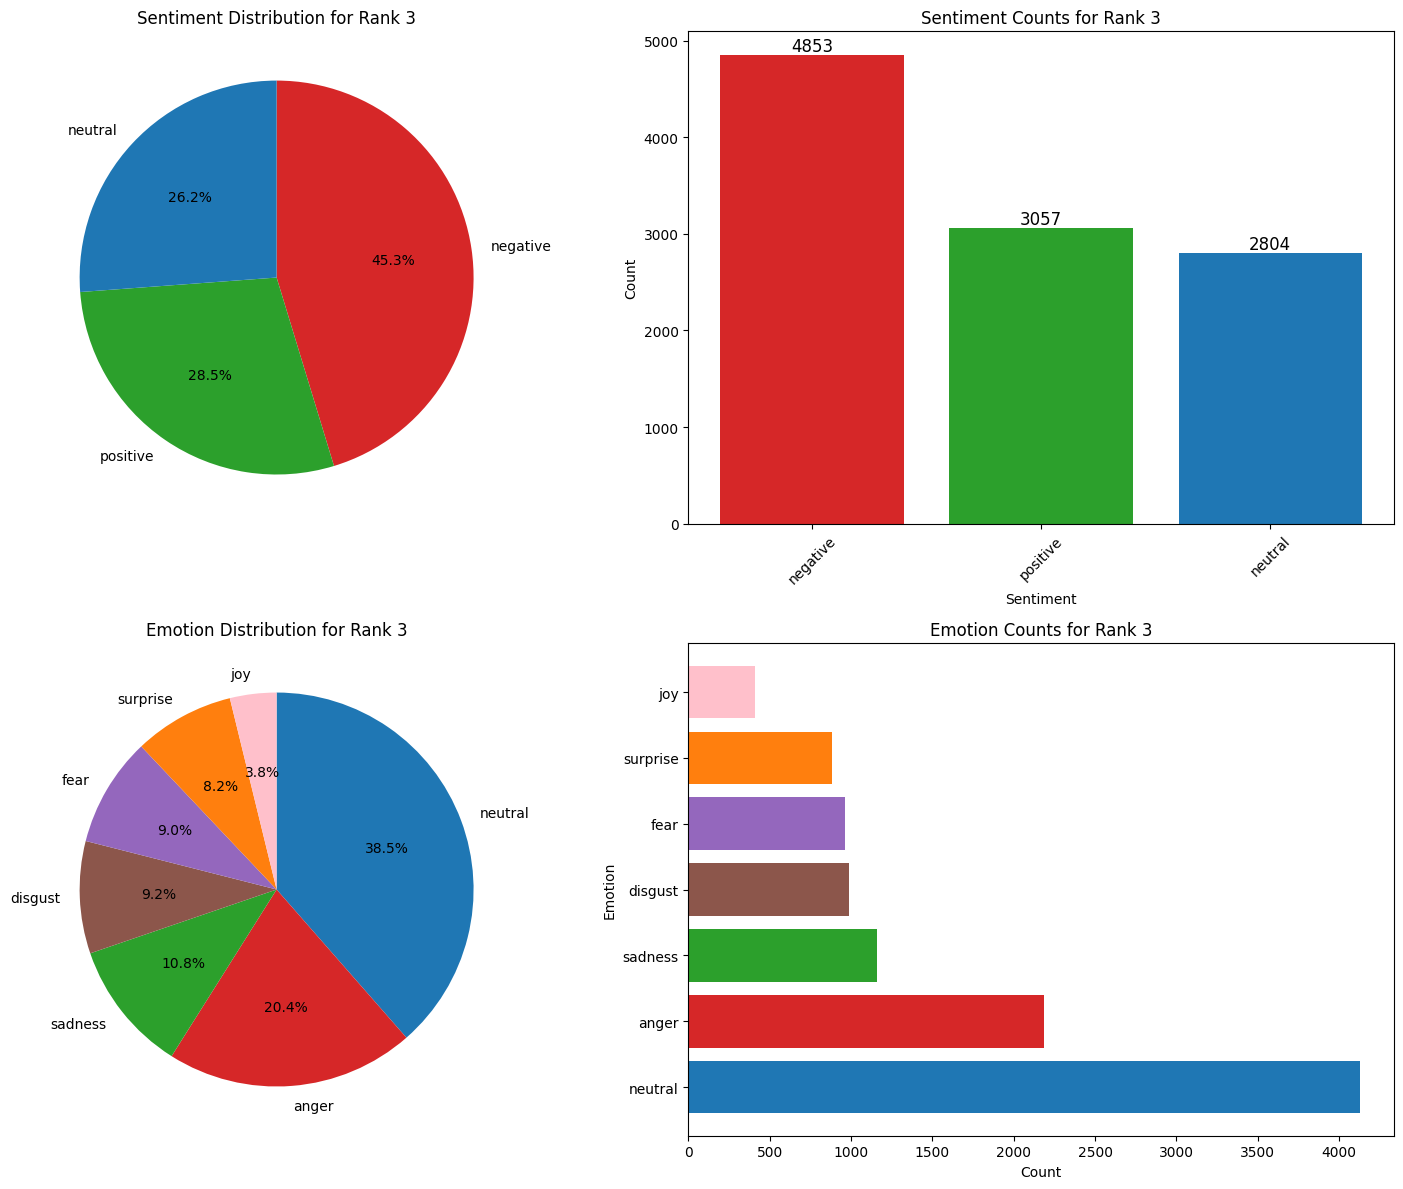

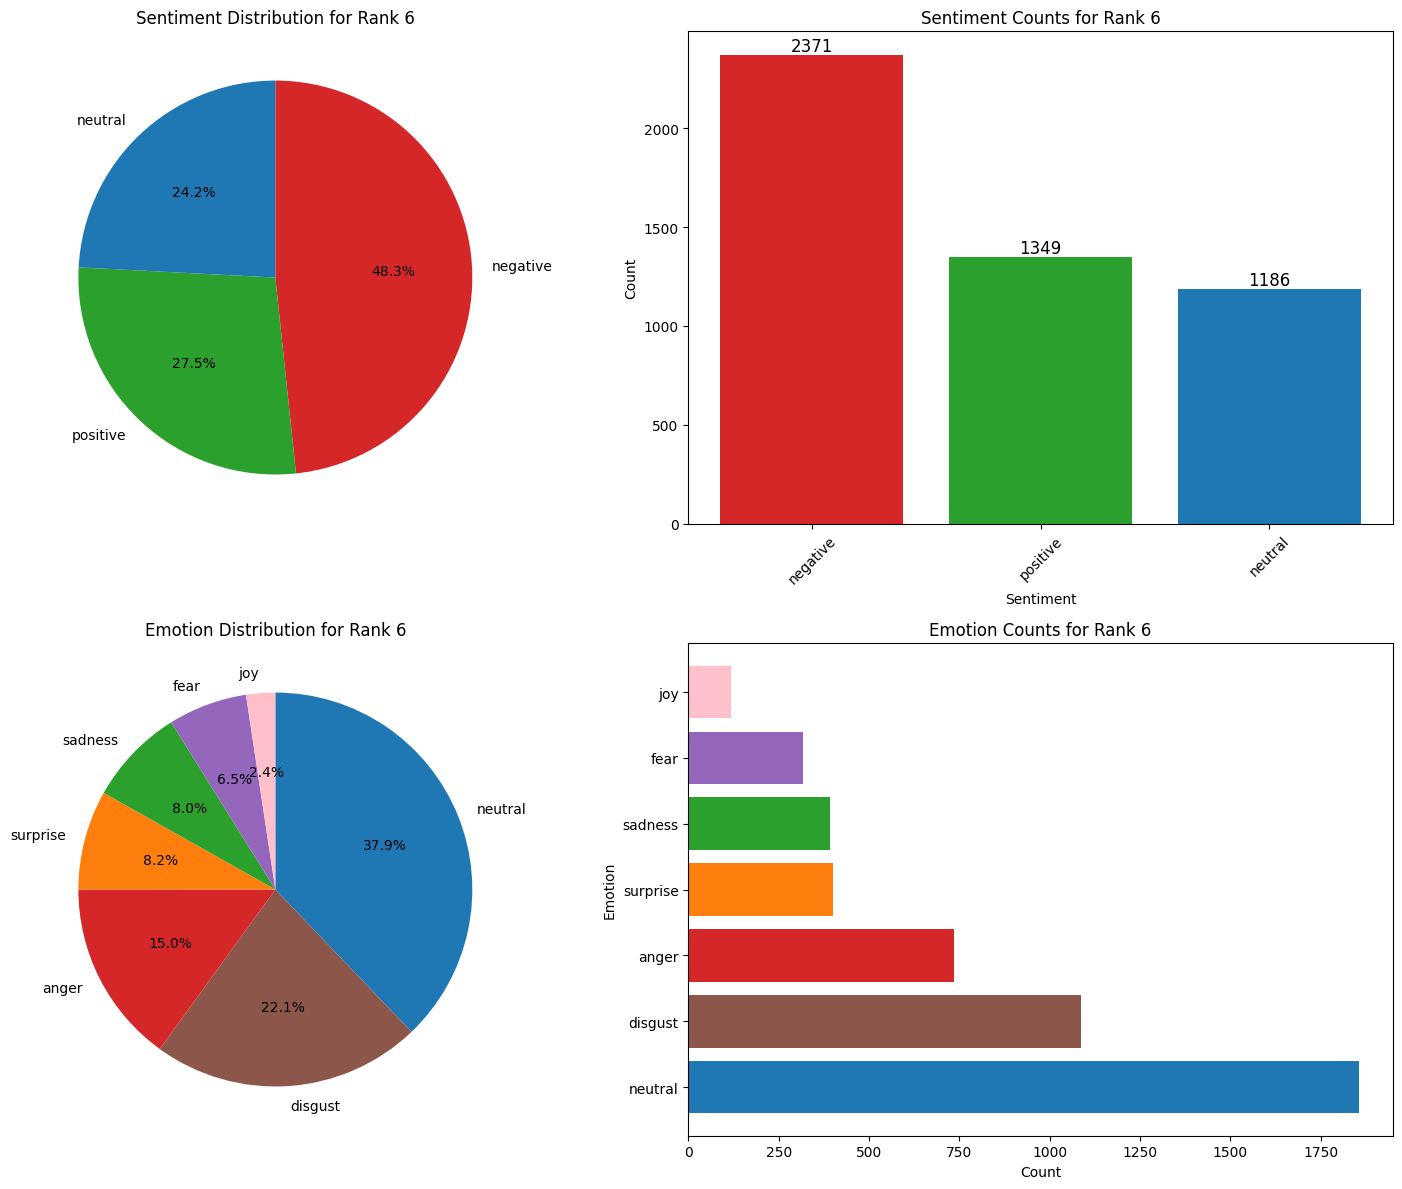

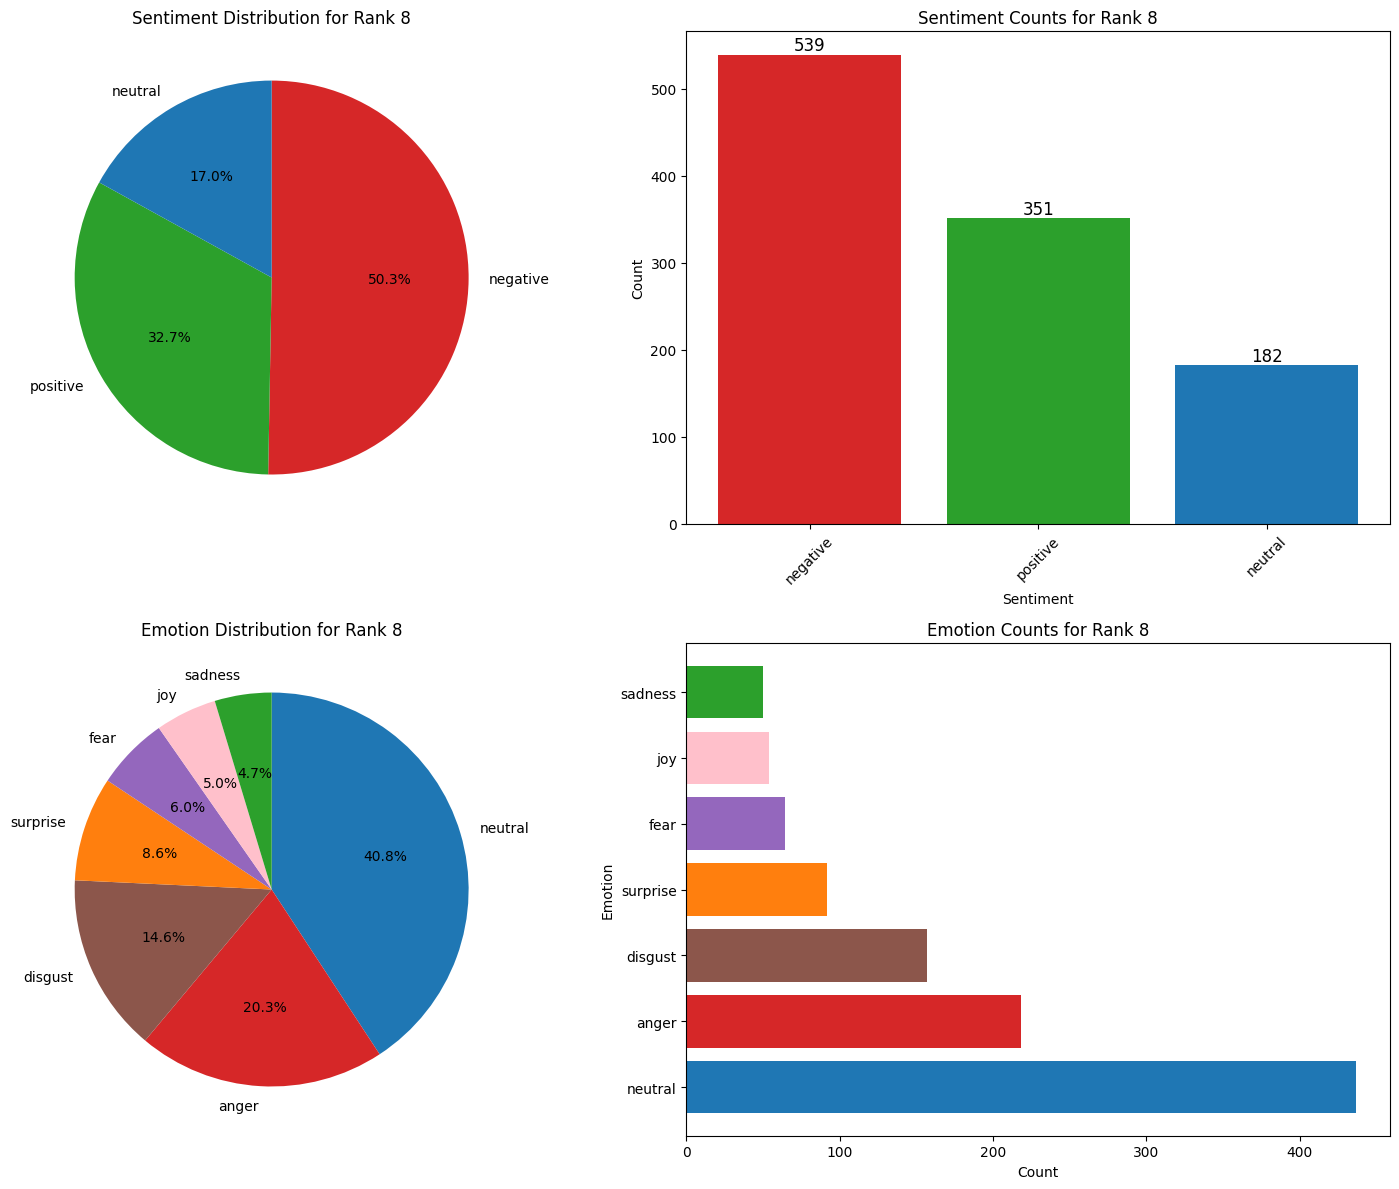

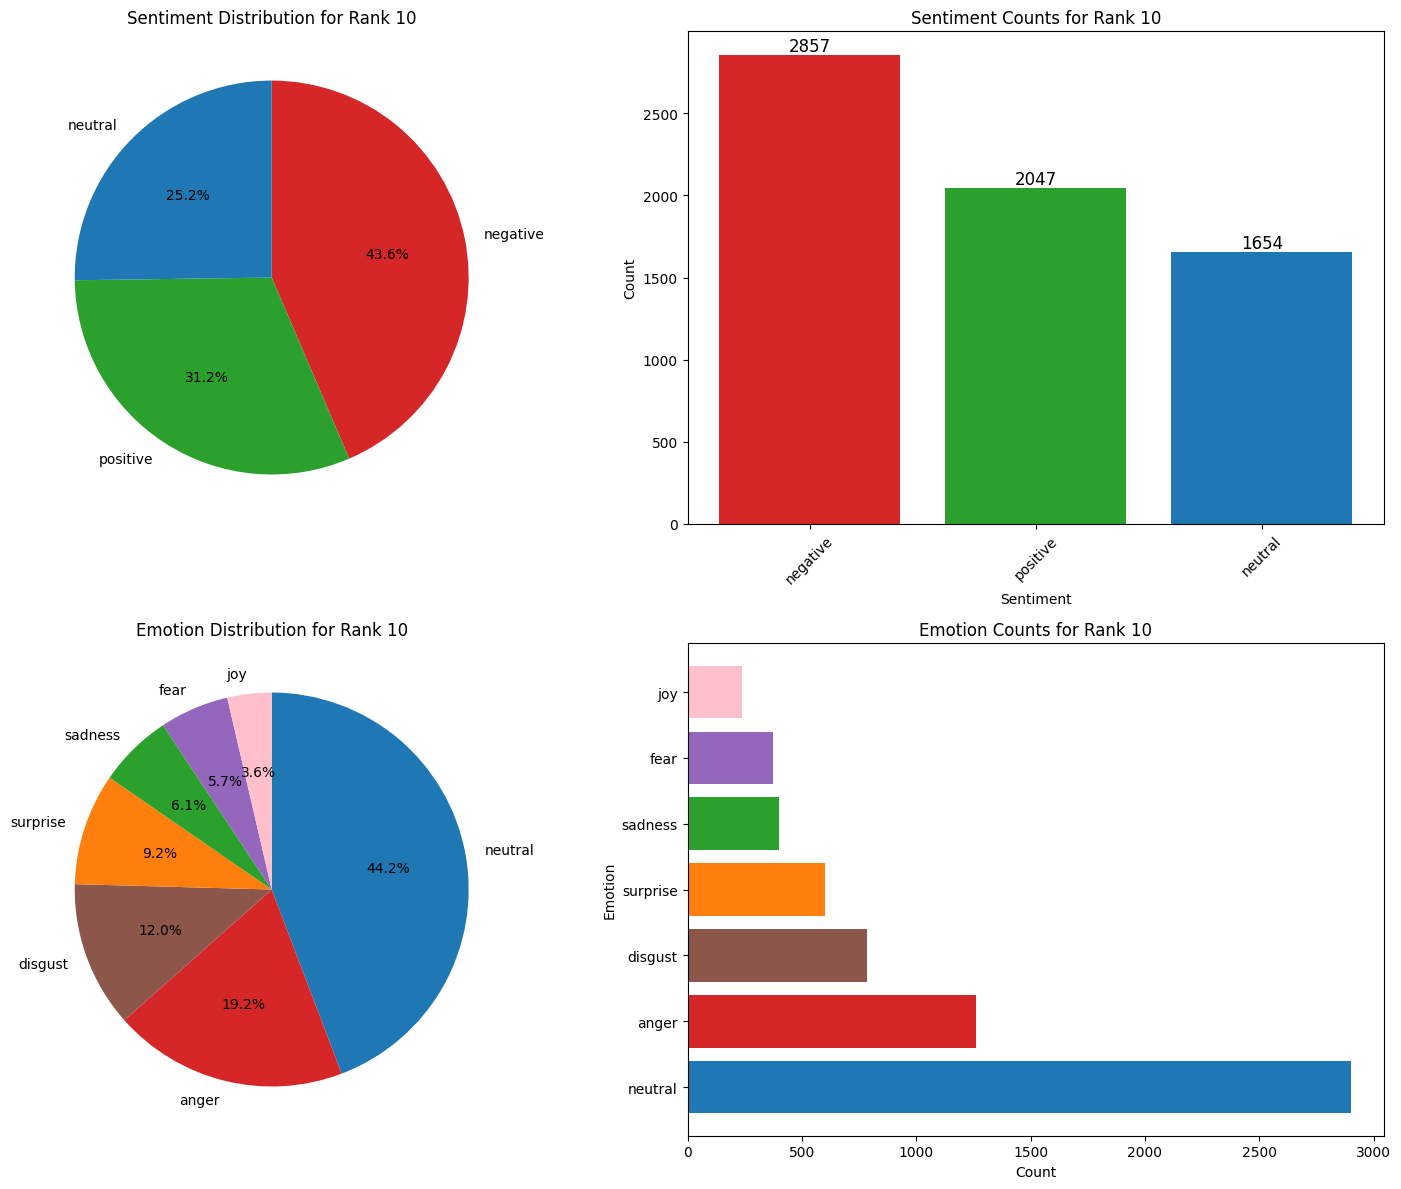

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a fixed color mapping for sentiment
color_mapping = {'positive': '#2ca02c', 'neutral': '#1f77b4', 'negative': '#d62728'}  # Green, Blue, Red

# Define a fixed color mapping for emotions
emotion_color_mapping = {
    'joy': 'pink',       # Pink
    'sadness': '#2ca02c',   # Green
    'anger': '#d62728',     # Red
    'surprise': '#ff7f0e',  # Orange
    'fear': '#9467bd',      # Purple
    'disgust': '#8c564b',   # Brown
    'neutral': '#1f77b4'    # Blue
}

# Define ranks (example)
ranks = df_comments['rank'].unique()

# Iterate over each rank
for rank in ranks:
    # Filter the dataframe by the current rank
    df_rank = df_comments[df_comments['rank'] == rank]

    # Create a figure for the four plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))  # 2x2 grid of subplots

    # ------------------------ Sentiment Distribution (Pie Chart) ------------------------
    sentiment_counts = df_rank['sentiment_class'].value_counts()
    colors = [color_mapping[label] for label in sentiment_counts.index]

    axes[0, 0].pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=colors, startangle=90, counterclock=False)
    axes[0, 0].set_title(f'Sentiment Distribution for Rank {rank}')

    # ------------------------ Sentiment Counts (Bar Plot) ------------------------
    axes[0, 1].bar(sentiment_counts.index, sentiment_counts.values, color=colors)
    axes[0, 1].set_title(f'Sentiment Counts for Rank {rank}')
    axes[0, 1].set_xlabel('Sentiment')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Add numbers on top of the bars (without decimals)
    for i, value in enumerate(sentiment_counts.values):
        axes[0, 1].text(i, value + 0.5, str(int(value)), ha='center', va='bottom', fontsize=12)

    # ------------------------ Emotion Distribution (Pie Chart) ------------------------
    emotion_counts = df_rank['emotion'].value_counts()
    colors = [emotion_color_mapping[label] for label in emotion_counts.index]

    axes[1, 0].pie(emotion_counts, labels=emotion_counts.index, autopct='%1.1f%%', colors=colors, startangle=90, counterclock=False)
    axes[1, 0].set_title(f'Emotion Distribution for Rank {rank}')

    # ------------------------ Emotion Counts (Bar Plot) ------------------------
    axes[1, 1].barh(emotion_counts.index, emotion_counts.values, color=colors)
    axes[1, 1].set_title(f'Emotion Counts for Rank {rank}')
    axes[1, 1].set_xlabel('Count')
    axes[1, 1].set_ylabel('Emotion')

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()


_Everything Combined_


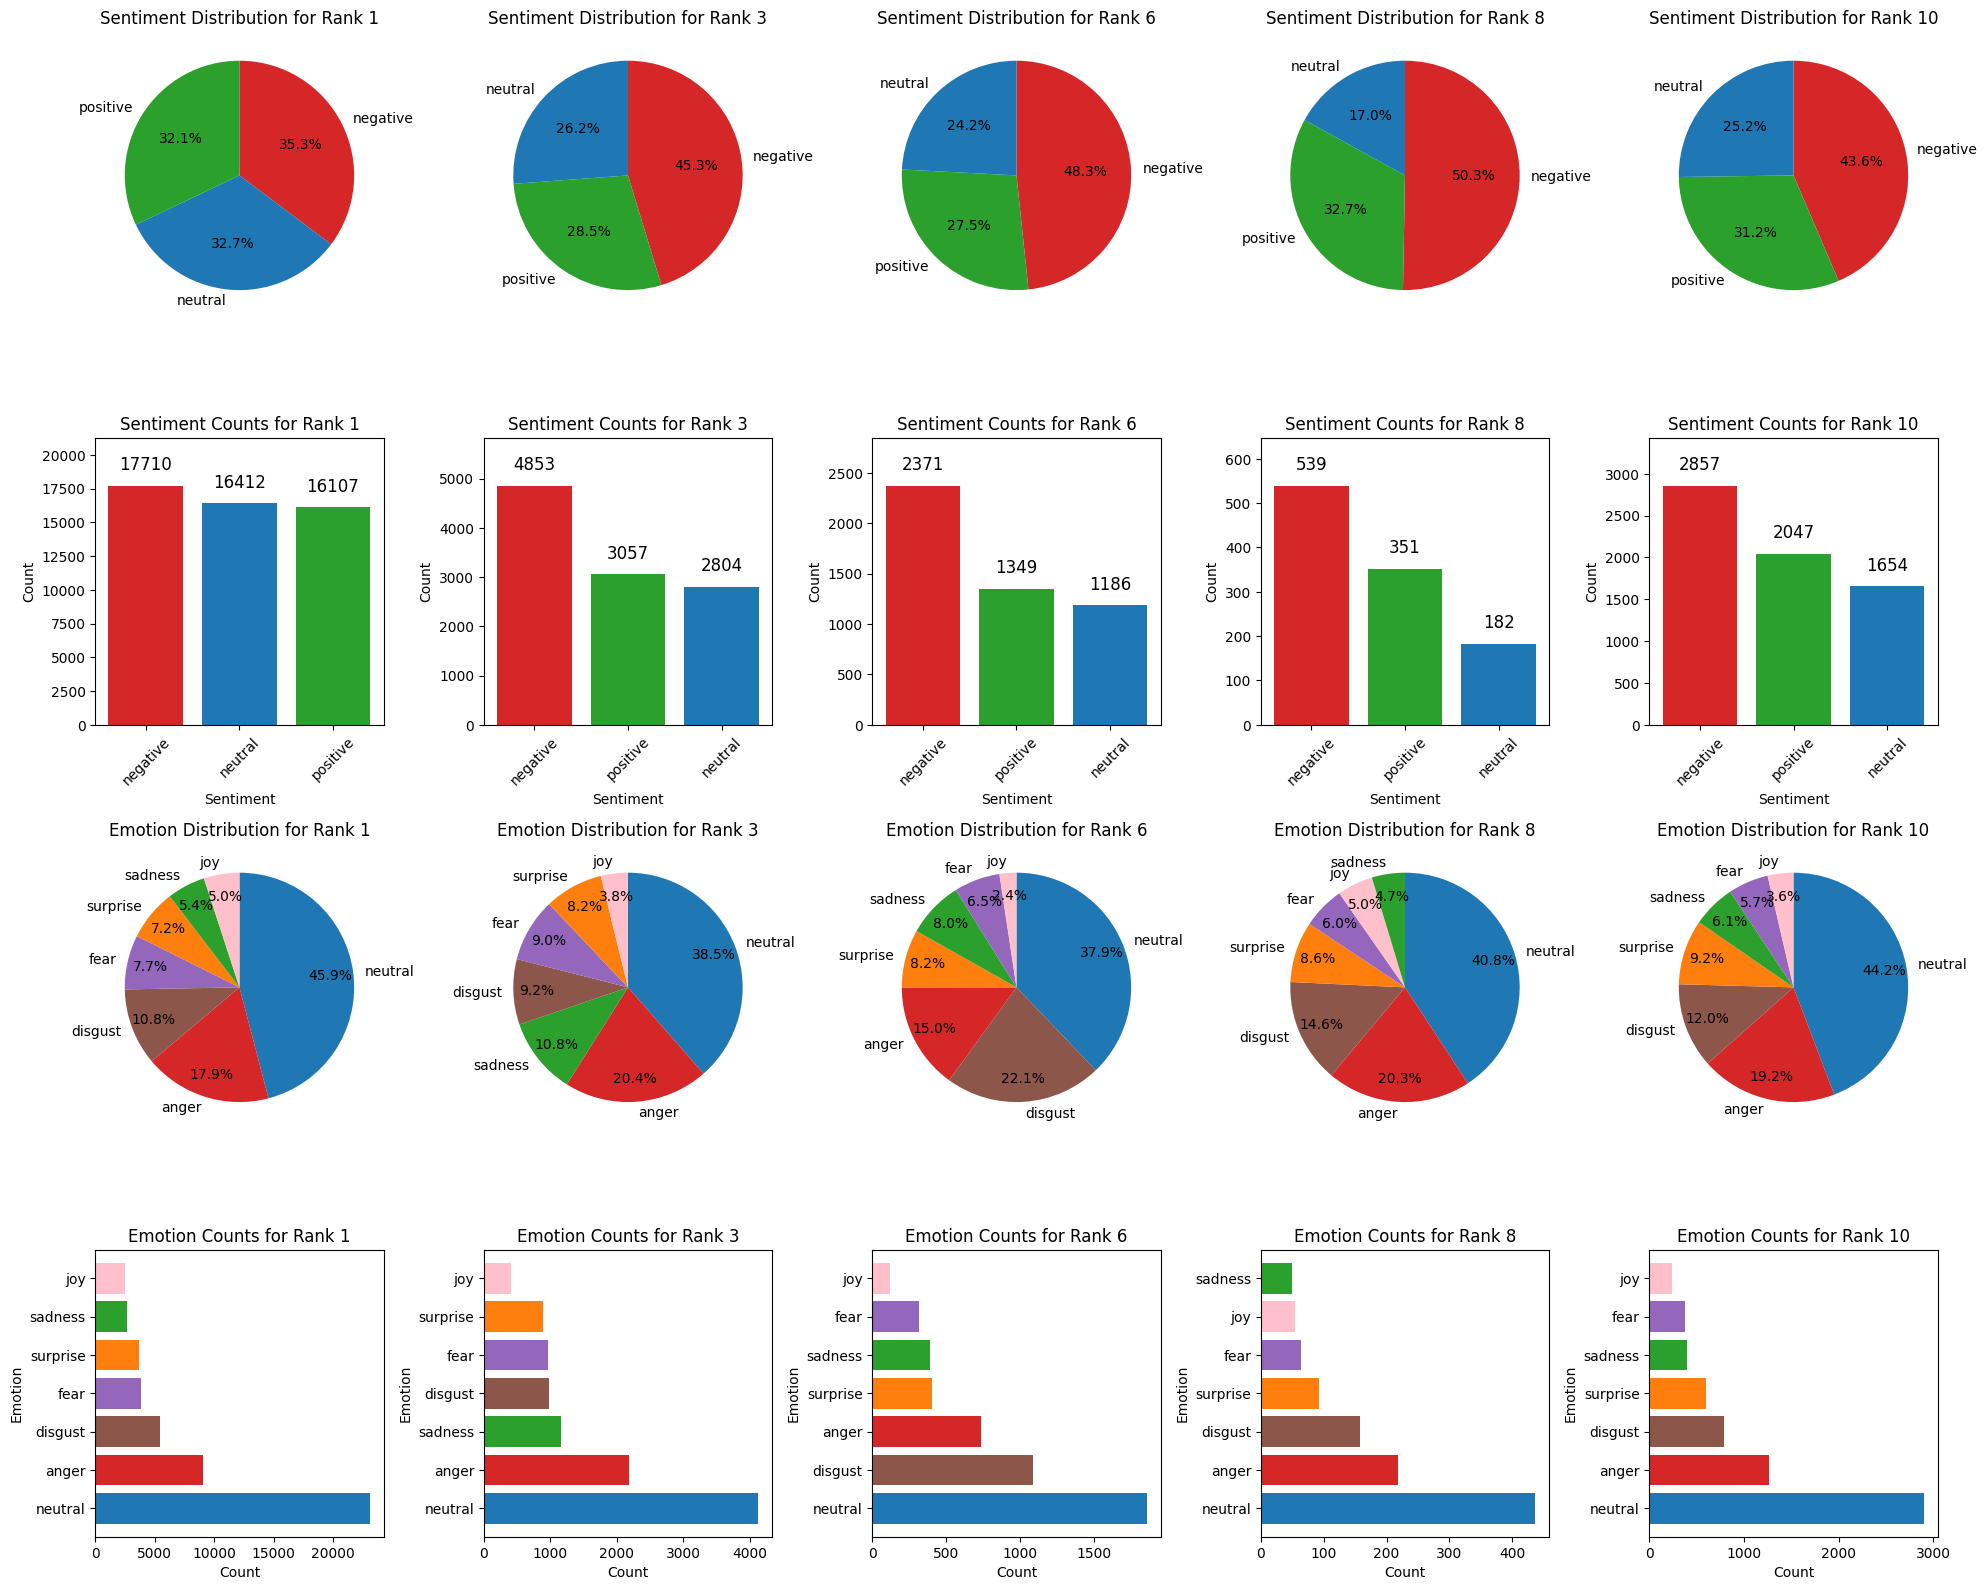

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a fixed color mapping for sentiment
color_mapping = {'positive': '#2ca02c', 'neutral': '#1f77b4', 'negative': '#d62728'}  # Green, Blue, Red

# Define a fixed color mapping for emotions
emotion_color_mapping = {
    'joy': 'pink',       # Pink
    'sadness': '#2ca02c',   # Green
    'anger': '#d62728',     # Red
    'surprise': '#ff7f0e',  # Orange
    'fear': '#9467bd',      # Purple
    'disgust': '#8c564b',   # Brown
    'neutral': '#1f77b4'    # Blue
}

# Define ranks (example)
ranks = df_comments['rank'].unique()

# Create a figure for all plots (4 rows, 5 columns)
fig, axes = plt.subplots(4, 5, figsize=(20, 16))  # 4 rows, 5 columns

# Iterate over each rank (columns in the subplot)
for idx, rank in enumerate(ranks):
    # Filter the dataframe by the current rank
    df_rank = df_comments[df_comments['rank'] == rank]

    # ------------------------ Sentiment Distribution (Pie Chart) ------------------------
    sentiment_counts = df_rank['sentiment_class'].value_counts()
    colors = [color_mapping[label] for label in sentiment_counts.index]
    
    axes[0, idx].pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=colors, startangle=90, counterclock=False)
    axes[0, idx].set_title(f'Sentiment Distribution for Rank {rank}')
    axes[0, idx].set_ylabel('')

    # ------------------------ Sentiment Counts (Bar Plot) ------------------------
    axes[1, idx].bar(sentiment_counts.index, sentiment_counts.values, color=colors)
    axes[1, idx].set_title(f'Sentiment Counts for Rank {rank}')
    axes[1, idx].set_xlabel('Sentiment')
    axes[1, idx].set_ylabel('Count')
    axes[1, idx].tick_params(axis='x', rotation=45)

    # Add numbers on top of the bars (without decimals), with adjusted y-position
    for i, value in enumerate(sentiment_counts.values):
        axes[1, idx].text(i, value + 0.05 * sentiment_counts.max(),  # Add a fraction of the max value for spacing
                        str(int(value)), ha='center', va='bottom', fontsize=12)

    # Ensure there's a little padding at the top of the plot to avoid clipping
    axes[1, idx].set_ylim(0, sentiment_counts.max() * 1.2)  # Increase the upper limit by 10%

    # ------------------------ Emotion Distribution (Pie Chart) ------------------------
    emotion_counts = df_rank['emotion'].value_counts()
    colors = [emotion_color_mapping[label] for label in emotion_counts.index]

    # Adjust the autopct format and pctdistance to avoid overlap
    axes[2, idx].pie(
        emotion_counts, 
        labels=emotion_counts.index, 
        autopct='%1.1f%%',  # Format the percentages
        colors=colors, 
        startangle=90, 
        counterclock=False,
        pctdistance=0.8  # Reduce distance from the center to avoid overlap
    )

    axes[2, idx].set_title(f'Emotion Distribution for Rank {rank}')
    axes[2, idx].set_ylabel('')


    # ------------------------ Emotion Counts (Bar Plot) ------------------------
    axes[3, idx].barh(emotion_counts.index, emotion_counts.values, color=colors)
    axes[3, idx].set_title(f'Emotion Counts for Rank {rank}')
    axes[3, idx].set_xlabel('Count')
    axes[3, idx].set_ylabel('Emotion')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


WRITE DF TO SEE VISUALIZATIONS AS NUMBERS


In [ ]:
import pandas as pd

# Initialize a dictionary to store results
result_dict = {
    'Metric': [
        'dist_pos', 'dist_neu', 'dist_neg', 
        'count_pos', 'count_neu', 'count_neg',
        'dist_joy', 'dist_sad', 'dist_surprise', 'dist_fear', 
        'dist_disgust', 'dist_anger', 'dist_neutral', 
        'count_joy', 'count_sad', 'count_surprise', 
        'count_fear', 'count_disgust', 'count_anger', 'count_neutral'
    ]
}

# Overall sentiment and emotion distributions (calculated for the entire dataset first)
overall_sentiment_counts = df_comments['sentiment_class'].value_counts()
overall_sentiment_dist = (overall_sentiment_counts / overall_sentiment_counts.sum()) * 100
overall_emotion_counts = df_comments['emotion'].value_counts()
overall_emotion_dist = (overall_emotion_counts / overall_emotion_counts.sum()) * 100

# Adding overall data to the result dictionary
result_dict['Overall'] = [
    overall_sentiment_dist.get('positive', 0),  # dist_pos
    overall_sentiment_dist.get('neutral', 0),   # dist_neu
    overall_sentiment_dist.get('negative', 0),  # dist_neg
    overall_sentiment_counts.get('positive', 0),  # count_pos
    overall_sentiment_counts.get('neutral', 0),   # count_neu
    overall_sentiment_counts.get('negative', 0),  # count_neg
    overall_emotion_dist.get('joy', 0),         # dist_joy
    overall_emotion_dist.get('sadness', 0),     # dist_sad
    overall_emotion_dist.get('surprise', 0),    # dist_surprise
    overall_emotion_dist.get('fear', 0),        # dist_fear
    overall_emotion_dist.get('disgust', 0),     # dist_disgust
    overall_emotion_dist.get('anger', 0),       # dist_anger
    overall_emotion_dist.get('neutral', 0),     # dist_neutral
    overall_emotion_counts.get('joy', 0),       # count_joy
    overall_emotion_counts.get('sadness', 0),   # count_sad
    overall_emotion_counts.get('surprise', 0),  # count_surprise
    overall_emotion_counts.get('fear', 0),      # count_fear
    overall_emotion_counts.get('disgust', 0),   # count_disgust
    overall_emotion_counts.get('anger', 0),     # count_anger
    overall_emotion_counts.get('neutral', 0),   # count_neutral
]

# Iterate over each rank and calculate sentiment and emotion distributions and counts
for rank in ranks:
    df_rank = df_comments[df_comments['rank'] == rank]

    # Sentiment statistics for the current rank
    sentiment_counts = df_rank['sentiment_class'].value_counts()
    sentiment_dist = (sentiment_counts / sentiment_counts.sum()) * 100

    # Emotion statistics for the current rank
    emotion_counts = df_rank['emotion'].value_counts()
    emotion_dist = (emotion_counts / emotion_counts.sum()) * 100

    # Add rank data to the result dictionary
    result_dict[f'Rank{rank}'] = [
        sentiment_dist.get('positive', 0),  # dist_pos
        sentiment_dist.get('neutral', 0),   # dist_neu
        sentiment_dist.get('negative', 0),  # dist_neg
        sentiment_counts.get('positive', 0),  # count_pos
        sentiment_counts.get('neutral', 0),   # count_neu
        sentiment_counts.get('negative', 0),  # count_neg
        emotion_dist.get('joy', 0),         # dist_joy
        emotion_dist.get('sadness', 0),     # dist_sad
        emotion_dist.get('surprise', 0),    # dist_surprise
        emotion_dist.get('fear', 0),        # dist_fear
        emotion_dist.get('disgust', 0),     # dist_disgust
        emotion_dist.get('anger', 0),       # dist_anger
        emotion_dist.get('neutral', 0),     # dist_neutral
        emotion_counts.get('joy', 0),       # count_joy
        emotion_counts.get('sadness', 0),   # count_sad
        emotion_counts.get('surprise', 0),  # count_surprise
        emotion_counts.get('fear', 0),      # count_fear
        emotion_counts.get('disgust', 0),   # count_disgust
        emotion_counts.get('anger', 0),     # count_anger
        emotion_counts.get('neutral', 0),   # count_neutral
    ]

# Convert the result dictionary to a pandas DataFrame
result_df = pd.DataFrame(result_dict)

# Save the DataFrame as a CSV
result_df.to_csv('vizualization_numbers.csv', index=False)

print("CSV with emotion and sentiment counts by rank has been saved.")


CSV with emotion and sentiment counts by rank has been saved.
